# Moment dynamics with cell division

(c) 2017 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT)

---

In [1]:
import pickle
import cloudpickle
import itertools

# Our numerical workhorses
import numpy as np
import scipy as sp
import pandas as pd

# Import library to perform maximum entropy fits
from maxentropy.skmaxent import FeatureTransformer, MinDivergenceModel

# Import libraries to parallelize processes
from joblib import Parallel, delayed

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# Import the utils for this project
import chann_cap_utils as chann_cap

# Set PBoC plotting style
chann_cap.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline
%config InlineBackend.figure_format = 'svg'

tmpdir = '../../tmp/'
figdir = '../../fig/moment_dynamics_numeric/'
datadir = '../../data/csv_maxEnt_dist/'

### $\LaTeX$ macros
$\newcommand{kpon}{k^{(p)}_{\text{on}}}$
$\newcommand{kpoff}{k^{(p)}_{\text{off}}}$
$\newcommand{kron}{k^{(r)}_{\text{on}}}$
$\newcommand{kroff}{k^{(r)}_{\text{off}}}$
$\newcommand{rm}{r _m}$
$\newcommand{gm}{\gamma _m}$
$\newcommand{mm}{\left\langle m \right\rangle}$
$\newcommand{ee}[1]{\left\langle #1 \right\rangle}$
$\newcommand{bb}[1]{\mathbf{#1}}$
$\newcommand{foldchange}{\text{fold-change}}$

## Distribution moment dynamics with cell division 

As first discussed by Jones et al. and then further expanded by [Peterson et al.](http://www.pnas.org/content/112/52/15886) the effect of having multiple gene copy numbers due to genome replication during the cell cycle has an important effect on gene expression noise. As the genome is replicated the cells spend part of their cell cycle with > 1 copy of the gene. The number of copies depends on the growth rate and on the gene position relative to the genome replication origin.

For our experimental setup we know from Jones et al. that our cells spend 2/3 of the cell cycle with 2 copies of the reporter gene and 1/3 with one copy. We previously inferred the parameters $\kpon$, $\kpoff$, and $r_m$ assuming that at both stages the mRNA reached steady state with $r_m$ as production rate for 1 gene copy and $2 r_m$ for two copies. The objective of this notebook is to explore the dynamical consequences of these gene copy number variations at the level of the mRNA and protein distribution moments.

The first thing we need to establish are the dynamics for the mRNA. The cell doubling time $t_d \approx 60$ min establishes the period of the cell cycle. For a time $0 < t_s < t_d$ cells have 1 copy of the gene (i.e. mRNA production rate $r_m$) and for the rest of the cycle the cells have 2 copies of the gene (i.e. mRNA production rate of $2 r_m$).

Therefore for our simulations we will initialize the moments at the steady state values for the single promoter, run the simulation with those parameters for time 0 to $t_s$ and then change the parameters for the rest of the simulation until reaching time $t_d$.

### Cell division

After cells reach time $t_d$ the content of the cells is assumed to divide as the cells split into two daughter cells. To account for this division we will assume that the mean mRNA (and later on protein) count are halved. Given the dependence of higher moments on the first moment we will "re-initialize" the value of the other moments assuming the values that one would obtain if this halved mean mRNA count was the steady state value. 

In other words assume that the mean mRNA count at time $t_d$ is given by $\ee{m(t_d)}$. After this time we reset the initial condition for the simulation with one promoter to be $\ee{m(t=0)} = {\ee{m(t_d)} \over 2}$. By fixing the first moment values higher moments of the mRNA distirbution $\ee{m^x}$ will be computed by finding what the steady state value would be given the value of the first moment. Note that this will not strictly give the same values as just computing the steady state value of the moments. If the initial condition $\ee{m(t=0)}$ is not the same as steady state condition $\ee{m}_{ss}$ the values that the other moments will also differ from the steady state values.

The reason for this convoluted assumption is that dividing the first moment in half after cell division makes sense, but it is not clear that the same assumption applies for higher moments of the distribution. To gain intuition about this assume that the mRNA distribution is binomial with mean value $\ee{m(t_d)} = N p$. Dividing this by half for the initial condition is easy since we would have $\ee{m(t=0)} = {N p \over 2}$. The second moment before the cell division would be of the form $\ee{m^2(t_d)} = Np - Np^2 + N^2p^2$. Therefore dividing this value by two for the initial condition of the next cell cycle doesn't translate to the second moment one would expect for a binomial distribution with mean ${Np \over 2}$.

## Defining mRNA dynamics 

We will now define functions to compute the first 3 mRNA distribution moments. The PDEs that define these moments are given by
\begin{align}
% zeroth moment
{d \over dt} \ee{\bb{m}^0} &= \mathbf{K}_m \left\langle \mathbf{m}^0 \right\rangle, \\
%first moment
{d \over dt}\ee{\bb{m}^1} &= 
\left( \mathbf{K}_m - \mathbf{\Gamma}_m  \right)\ee{\bb{m}^1}
             + \mathbf{R}_m \left\langle \mathbf{m}^0 \right\rangle, \\
% second moment
{d\ee{\bb{m}^2} \over dt} &= \left( \mathbf{K}^u_m - 2 \mathbf{\Gamma}^u_n \right) 
             \left\langle \mathbf{m}^2 \right\rangle
             + \left( 2 \mathbf{R}^u_m + \mathbf{\Gamma}^u_m \right)
             \left\langle \mathbf{m}^1 \right\rangle
             + \mathbf{R}^u_m
             \left\langle \mathbf{m}^0 \right\rangle,  \\
% third moment
{d\ee{\bb{m}^3} \over dt} &= \left( \mathbf{K}_m - 3 \mathbf{\Gamma}_n \right) 
             \left\langle \mathbf{m}^3 \right\rangle
             + \left( 3 \mathbf{R}_m + 3 \mathbf{\Gamma}_m \right)
             \left\langle \mathbf{m}^2 \right\rangle
             + \left( 3 \mathbf{R}_m - \mathbf{\Gamma}_m \right)
             \left\langle \mathbf{m}^1 \right\rangle
             + \mathbf{R}_m
             \left\langle \mathbf{m}^0 \right\rangle.
\end{align}

From these equations it is clear that the second and third moment depend on the value of the first (and zeroth) moment. For the first function `dmdt` the equations for the first and zeroth moment will be included in the numerical integration. For the second function `dmdt_init` the values for $\left\langle \mathbf{m}^0 \right\rangle$ and $\left\langle \mathbf{m}^1 \right\rangle$ are assumed to be fixed and the rest of the moments are computed accordingly.

In [2]:
def dmdt(m, t, Kmat, Rmat, Gmat):
    '''
    function to integrate dm / dt using scipy.integrate.odeint
    Parameters
    ----------
    m : array-like.
        Array containing the zeroth, first, second and third moment 
        of the states of the promoter.
        Unregulated
        m[0] = m0_P (RNAP bound)
        m[1] = m0_E (Empty promoter)
        m[2] = m1_P (RNAP bound)
        m[3] = m1_P (Empty promoter)
        m[4] = m2_P (RNAP bound)
        m[5] = m2_P (Empty promoter)
        m[6] = m3_P (RNAP bound)
        m[7] = m3_P (Empty promoter)
        ---------
        Regulated:
        m[0] = m0_P (RNAP bound)
        m[1] = m0_E (Empty promoter)
        m[2] = m0_R (Repressor bound) 
        m[3] = m1_P (RNAP bound)
        m[4] = m1_E (Empty promoter)
        m[5] = m1_R (Repressor bound) 
        m[6] = m2_P (RNAP bound)
        m[7] = m2_E (Empty promoter)
        m[8] = m2_R (Repressor bound) 
        m[9] = m3_P (RNAP bound)
        m[10] = m3_E (Empty promoter)
        m[11] = m3_R (Repressor bound) 
    t : array-like.
        Time array
    Kmat : array-like.
        Matrix containing the transition rates between the promoter states.
    Rmat : array-like.
        Matrix containing the production rate at each of the states.
    Gmat : array-like.
        Matrix containing the degradation rate at each of the states.   
        
    Returns
    -------
    numerical integration of the differential equations
    '''
    # Obtain the zeroth and first moment based on the size 
    # of the Kmat matrix
    if Kmat.shape[0] == 2:
        m0 = m[0:2]
        m1 = m[2:4]
        m2 = m[4:6]
        m3 = m[6::]
    elif Kmat.shape[0] == 3:
        m0 = m[0:3]
        m1= m[3:6]
        m2= m[6:9]
        m3= m[9::]
    
    # Compute the moment equations for the:
    # Zeroth moment
    dm0dt_eq = np.dot(Kmat, m0)
    # First moment
    dm1dt_eq = np.dot((Kmat - Gmat), m1) + np.dot(Rmat, m0)
    # Second moment
    dm2dt_eq = np.dot((Kmat - 2 * Gmat), m2) + np.dot((2 * Rmat + Gmat), m1) +\
                np.dot(Rmat, m0)
    # Third moment
    dm3dt_eq = np.dot((Kmat - 3 * Gmat), m3) +\
                np.dot((3 * Rmat + 3 * Gmat), m2) +\
                np.dot((3 * Rmat - Gmat), m1) +\
                np.dot(Rmat, m0)
    
    return np.append(dm0dt_eq, 
                     np.append(dm1dt_eq, 
                               np.append(dm2dt_eq, dm3dt_eq)))

def dmdt_init(m, t, m_fix, Kmat, Rmat, Gmat):
    '''
    function to integrate dm / dt using scipy.integrate.odeint
    This funciton assumes that the zeroth and first moment are fixed
    and computes the corresponding second and third moments accordingly.
    Parameters
    ----------
    m : array-like.
        Array containing the second and third moment 
        of the states of the promoter.
        Unregulated
        m[0] = m2_P (RNAP bound)
        m[1] = m2_E (Empty promoter)
        m[2] = m3_P (RNAP bound)
        m[3] = m3_E (Empty promoter)
        ---------
        Regulated: 
        m[0] = m2_P (RNAP bound)
        m[1] = m2_E (Empty promoter)
        m[2] = m2_R (Repressor bound) 
        m[3] = m3_P (RNAP bound)
        m[4] = m3_E (Empty promoter)
        m[5] = m3_R (Repressor bound)    
    t : array-like.
        Time array
    m_fix : array-like.
        Array containing the zerot and first moment 
        of the states of the promoter that will remain fixed.
        Unregulated
        m_fix[0] = m0_P (RNAP bound)
        m_fix[1] = m0_E (Empty promoter)
        m_fix[2] = m1_P (RNAP bound)
        m_fix[3] = m1_E (Empty promoter)
    ---------
    Regulated:
        m_fix[0] = m0_P (RNAP bound)
        m_fix[1] = m0_E (Empty promoter)
        m_fix[2] = m0_R (Repressor bound) 
        m_fix[3] = m1_P (RNAP bound)
        m_fix[4] = m1_E (Empty promoter)
        m_fix[5] = m1_R (Repressor bound)
    Kmat : array-like.
        Matrix containing the transition rates between the promoter states.
    Rmat : array-like.
        Matrix containing the production rate at each of the states.
    Gmat : array-like.
        Matrix containing the degradation rate at each of the states.   
        
    Returns
    -------
    2nd and 3rd moment dynamics given fixed 0th and 1st moment
    '''
    # Obtain the zeroth and first moment based on the size 
    # of the Kmat matrix
    if Kmat.shape[0] == 2:
        m0 = m_fix[0:2]
        m1 = m_fix[2::]
        m2 = m[0:2]
        m3 = m[2::]
    elif Kmat.shape[0] == 3:
        m0 = m_fix[0:3]
        m1= m_fix[3::]
        m2= m[0:3]
        m3= m[3::]
    
    # Compute the moment equations for the:
    # Second moment
    dm2dt_eq = np.dot((Kmat - 2 * Gmat), m2) + np.dot((2 * Rmat + Gmat), m1) +\
                np.dot(Rmat, m0)
    # Third moment
    dm3dt_eq = np.dot((Kmat - 3 * Gmat), m3) +\
                np.dot((3 * Rmat + 3 * Gmat), m2) +\
                np.dot((3 * Rmat - Gmat), m1) +\
                np.dot(Rmat, m0)
    
    return np.append(dm2dt_eq, dm3dt_eq)

### Defining function to compute moments over severall cell cycles

Having defined the functions to integrate the moment ODEs let's now define a function that given a time `t_single` that cells spend with one promoter copy and a time `t_double` that cells spend with two copies integrates the moments over several cell cycles.

In [3]:
def dmdt_cycles(m_init, t_single, t_double, n_cycles, 
                Kmat, Rmat, Gmat, n_steps=1000, t_ss=10000,
                states=['P', 'E']):
    '''
    Function that integrates the mRNA moments over several cell cycles.
    Parameters
    ----------
    m : array-like.
        Array containing the zeroth, first, second and third moment 
        of the states of the promoter.
        Unregulated
        m[0] = m0_P (RNAP bound)
        m[1] = m0_E (Empty promoter)
        m[2] = m1_P (RNAP bound)
        m[3] = m1_E (Empty promoter)
        m[4] = m2_P (RNAP bound)
        m[5] = m2_E (Empty promoter)
        m[6] = m3_P (RNAP bound)
        m[7] = m3_E (Empty promoter)
        ---------
        Regulated:
        m[0] = m0_P (RNAP bound)
        m[1] = m0_E (Empty promoter)
        m[2] = m0_R (Repressor bound) 
        m[3] = m1_P (RNAP bound)
        m[4] = m1_E (Empty promoter)
        m[5] = m1_R (Repressor bound) 
        m[6] = m2_P (RNAP bound)
        m[7] = m2_E (Empty promoter)
        m[8] = m2_R (Repressor bound) 
        m[9] = m3_P (RNAP bound)
        m[10] = m3_E (Empty promoter)
        m[11] = m3_R (Repressor bound)
    t_single : float.
        Time [in 1/mRNA degradation rate units] that cells spend 
        with a single promoter copy
    t_double : float.
        Time [in 1/mRNA degradation rate units] that cells spend 
        with a two promoter copies.
    n_cycles : int.
        Number of cell cycles to integrate for. A cell cycle is defined
        as t_single + t_double.
    Kmat : array-like.
        Matrix containing the transition rates between the promoter states.
    Rmat : array-like.
        Matrix containing the production rate at each of the states.
    Gmat : array-like.
        Matrix containing the degradation rate at each of the states.
    n_steps : int. Default = 300.
        Number of steps to use for the numerical integration.
    t_ss : float.
        Time to integrate for after cell division to compute the steady
        state value of higher moments.

    Returns
    -------
    mRNA moment dynamics over cell cycles
    '''
    # Initialize names for moments in data frame
    names = ['m' + str(mom) + '_' + st for mom in range(4) for st in states]
    
    # Initialize data frame
    df = pd.DataFrame(columns=['time', 'state', 'cycle'] + names)
    
    # Initilaize global time
    t_sim = 0
    # Loop through cycles
    for cyc in range(n_cycles):
        # == Single promoter == #
        # Define time array
        t = np.linspace(0, t_single, n_steps)

        # Integrate moment equations
        m = sp.integrate.odeint(dmdt, m_init, t, 
                             args=(Kmat, Rmat, Gmat))

        # Generate data frame
        df_m = pd.DataFrame(m, columns=names)
        # Append time, state and cycle
        df_m = df_m.assign(time=t + t_sim)
        df_m = df_m.assign(state=['single'] * m.shape[0])
        df_m = df_m.assign(cycle=[cyc] * m.shape[0])
        
        # Append results to global data frame
        df = df.append(df_m, ignore_index=True, sort=False)
        
        # Update global time
        t_sim = t_sim + t[-1]
        
        # == Two promoters == #
        
        # Define initial conditions as last point of single promoter state
        m_init = m[-1, :]
        
        # Define time array
        t = np.linspace(0, t_double, n_steps)

        # Integrate moment equations
        m = sp.integrate.odeint(dmdt, m_init, t, 
                             args=(Kmat, 2 * Rmat, Gmat))

        # Generate data frame
        df_m = pd.DataFrame(m, columns=names)
        # Append time, state and cycle
        df_m = df_m.assign(time=t + t_sim)
        df_m = df_m.assign(state=['double'] * m.shape[0])
        df_m = df_m.assign(cycle=[cyc] * m.shape[0])
        
        # Append results to global data frame
        df = df.append(df_m, ignore_index=True, sort=False)
        
        # Update global time
        t_sim = t_sim + t[-1]
        
        # == Cell division == #
        
        # Define time array
        t = np.linspace(0, t_ss, n_steps)
        
        # Define initial conditions as last point of single promoter state
        m_fix = m[-1, 0:(Kmat.shape[0]*2)]
        # Divide mean mRNA by half
        m_fix[(Kmat.shape[0])::] = m_fix[(Kmat.shape[0])::] / 2
        # Set initial condiitons for higher moments.
        m_init = m[-1, (Kmat.shape[0]*2)::]
        
        # Define initial conditions for moments after cell division
        m = sp.integrate.odeint(dmdt_init, m_init, t, 
                             args=(m_fix, Kmat, Rmat, Gmat))
        
        m_init = np.append(m_fix, m[-1, :])
        
    return df

# Two-state promoter
Having defined these functions let's first test them with the two-state unregulated promoter.

Let's define the necessary parameters.

In [4]:
# Define mRNA rate
# http://bionumbers.hms.harvard.edu/bionumber.aspx?id=105717&ver=3&trm=lacZ%20mRNA%20lifetime&org=
gm = 1 / (3 * 60)

# Load the flat-chain
with open('../../data/mcmc/lacUV5_constitutive_mRNA_double.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()

# Generate a Pandas Data Frame with the mcmc chain
index = ['kp_on', 'kp_off', 'rm']

# Generate a data frame out of the MCMC chains
df_mcmc = pd.DataFrame(gauss_flatchain, columns=index)

# rerbsine the index with the new entries
index = df_mcmc.columns

# map value of the parameters
max_idx = np.argmax(gauss_flatlnprobability, axis=0)
kp_on, kp_off, rm = df_mcmc.iloc[max_idx, :] * gm

Now we will define the state transition matrix $\mathbf{K}$, the mRNA production matrix $\mathbf{R}_m$ and the mRNA degradation matrix $\mathbf{\Gamma}_m$.

In [5]:
# Define the rate constant matrix
Kmat_unreg = np.array([[-kp_off, kp_on], 
                       [kp_off, -kp_on]])
# Define the production matrix
Rmat_unreg = np.array([[rm, 0], 
                       [0, 0]])
# Define the degradation matrix
Gmat_unreg = np.array([[gm, 0],
                       [0, gm]])

Having defined this let's integrate the equations for a long time to obtain the initial condition.

In [6]:
# Define time on which to perform integration
t = np.linspace(0, 100 * 60, 301)

# Define initial conditions
m0_init = [0.5, 0.5]
m1_init = [0, 0]
m2_init = [0, 0]
m3_init = [0, 0]

# Numerically integrate equations
m_init = sp.integrate.odeint(dmdt, m0_init + m1_init + m2_init + m3_init, t, 
                             args=(Kmat_unreg, Rmat_unreg, Gmat_unreg))

m_init = m_init[-1, :]

Let's now define the necesary inputs and run the numerical integration for several cell cycles.

In [7]:
# Define time for single-promoter state
t_single = 60 * 1 / 3 * 60 # sec
# Define time for two-promoter state
t_double = 60 * 2 / 3 * 60 # sec
# Define number of cell cycles
n_cycles = 3

# Integrate moment equations
df = dmdt_cycles(m_init, t_single, t_double, n_cycles, 
                 Kmat_unreg, Rmat_unreg, Gmat_unreg)

df_m_unreg = df

Now let's plot the first moment $\pm$ standard deviation.

In [8]:
# Extract index for first and second moment
first_mom_names = [x for x in df.columns if 'm1' in x]
second_mom_names = [x for x in df.columns if 'm2' in x]

# Compute the mean mRNA copy number
m_mean = df.loc[:, first_mom_names].sum(axis=1)

# Compute the variance
m_second = df.loc[:, second_mom_names].sum(axis=1)
m_var = (m_second - m_mean**2)

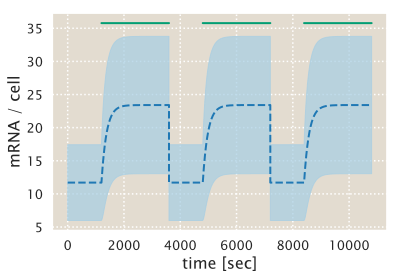

In [10]:
# Define color
colors = np.flip(sns.color_palette('Paired', n_colors=2), axis=0)

# Plot mean mRNA as solid line
plt.plot(df.time, m_mean, label=r'$\left\langle m \right\rangle$', 
         color=colors[0], linestyle='--')
# Plot +- standard deviation
plt.fill_between(df.time, m_mean - np.sqrt(m_var), m_mean + np.sqrt(m_var),
                 alpha=0.7, color=colors[1])

# Group data frame by cell cycle
df_group = df.groupby('cycle')
# Loop through cycles
for i, (group, data) in enumerate(df_group):
    # Find index for two-promoter state
    idx = data.state == 'double'
    # Indicate states with two promoters
    plt.plot(data.loc[idx, 'time'], 
             np.array([(m_mean + np.sqrt(m_var)).max() + 2] * len(data))[idx],
             color='g')

# Label plot
plt.xlabel('time [sec]')
_ = plt.ylabel('mRNA / cell')

We can see from this plot that the mRNA indeed seems to reach a steady state both when cells have one copy of the promoter, and when cells have two copies. This was expected given that the way that the mRNA production parameters were inferred in the first place assumed this steady state. This is just a confirmation that our numerical integration of the moment equations makes sense with what we expect.

It is important to highlight that we do not necessarily expect the same result for proteins since the time to steady state is set by the degradation rate, and the protein degradation rate for bacteria is assumed to be the dilution rate due to cell division.

## Defining Protein dynamics 

Having worked out the mRNA dynamics let's extend this approach to the protein dynamics. First let's list the ODEs for the moments.

### Protein moments (and cross correlations)
\begin{align}
% first moment
{d \ee{\bb{p}^1}\over dt} &=
\left( \mathbf{K} - \mathbf{\Gamma}_p  \right) \ee{\bb{p}^1}
+ \mathbf{R}_p \left\langle \mathbf{m} \right\rangle.\\
% <mp>
{d \ee{\bb{mp}}\over dt} &=
\left( \mathbf{K} - \mathbf{\Gamma}_m -  \mathbf{\Gamma}_p  \right)
\left\langle \mathbf{mp} \right\rangle 
+ \mathbf{R}_m \left\langle \mathbf{p} \right\rangle
+ \mathbf{R}_p \left\langle \mathbf{m}^2 \right\rangle \\
% second moment
{d \ee{\bb{p}^2}\over dt} &=
\left( \mathbf{K} - 2 \mathbf{\Gamma}_p \right) 
\left\langle \mathbf{p}^2 \right\rangle
+ \mathbf{\Gamma}_p \left\langle \mathbf{p} \right\rangle
+ \mathbf{R}_p \mm
+ 2 \mathbf{R}_p \left\langle \mathbf{mp} \right\rangle \\
% <m^2p>
{d \ee{\bb{m}^2\bb{p}}\over dt} &=   
\left( \bb{K} - 2 \bb{\Gamma}_m - \bb{\Gamma}_p \right) 
\ee{\bb{m}^2\bb{p}} +
\bb{R}_m \ee{\bb{p}} +
\left( 2 \bb{R}_m + \bb{\Gamma}_m \right) \ee{\bb{mp}} +
\bb{R}_p \ee{\bb{m}^3}.\\
% <mp^2>
{d \ee{\bb{m}\bb{p}^2}\over dt} &=   
\left( \bb{K} - \bb{\Gamma}_m - 2 \bb{\Gamma}_p \right)
\ee{\bb{mp}^2} +
\bb{R}_m \ee{\bb{p}^2} +
2 \bb{R}_p \ee{\bb{m}^2\bb{p}} +
\bb{R}_p \ee{\bb{m}^2} +
\bb{\Gamma}_p \ee{\bb{mp}}.\\
% third moment
{d \ee{\bb{p}^3}\over dt} &=
\left( \bb{K} - 3 \bb{\Gamma}_p \right) \ee{\bb{p}^3} +
3 \bb{\Gamma}_p \ee{\bb{p}^2} -
\bb{\Gamma}_p \ee{\bb{p}} +
3 \bb{R}_p \ee{\bb{mp}^2} +
3 \bb{R}_p \ee{\bb{mp}} +
\bb{R}_p \ee{\bb{m}}.
\end{align}

Let's now implemenet these equations into a function `dpdt`. And just as with the mRNA case we will define a function to compute the initial conditions after cell division `dpdt_init`.

In [11]:
def dpdt(mp, t, Kmat, Rm, Gm, Rp, Gp):
    '''
    function to integrate all mRNA and protein moment dynamics
    using scipy.integrate.odeint
    Parameters
    ----------
    m : array-like.
        Array containing all moments (mRNA, protein and cross correlations) 
        Unregulated
        mp[0] = m0_P (RNAP bound)
        mp[1] = m0_E (Empty promoter)
        mp[2] = m1_P (RNAP bound)
        mp[3] = m1_P (Empty promoter)
        mp[4] = m2_P (RNAP bound)
        mp[5] = m2_P (Empty promoter)
        mp[6] = m3_P (RNAP bound)
        mp[7] = m3_P (Empty promoter)
        mp[8] = p1_P (RNAP bound)
        mp[9] = p1_P (Empty promoter)
        mp[10] = mp_P (RNAP bound)
        mp[11] = mp_P (Empty promoter)
        mp[12] = p2_P (RNAP bound)
        mp[13] = p2_P (Empty promoter)
        mp[14] = m2p_P (RNAP bound)
        mp[15] = m2p_P (Empty promoter)
        mp[16] = mp2_P (RNAP bound)
        mp[17] = mp2_P (Empty promoter)
        mp[18] = p3_P (RNAP bound)
        mp[19] = p3_P (Empty promoter)
        ---------
        Regulated:
        mp[0] = m0_P (RNAP bound)
        mp[1] = m0_E (Empty promoter)
        mp[2] = m0_R (Repressor bound) 
        mp[3] = m1_P (RNAP bound)
        mp[4] = m1_E (Empty promoter)
        mp[5] = m1_R (Repressor bound) 
        mp[6] = m2_P (RNAP bound)
        mp[7] = m2_E (Empty promoter)
        mp[8] = m2_R (Repressor bound) 
        mp[9] = m3_P (RNAP bound)
        mp[10] = m3_E (Empty promoter)
        mp[11] = m3_R (Repressor bound) 
        mp[12] = p1_P (RNAP bound)
        mp[13] = p1_E (Empty promoter)
        mp[14] = p1_R (Repressor bound) 
        mp[15] = mp_P (RNAP bound)
        mp[16] = mp_E (Empty promoter)
        mp[17] = mp_R (Repressor bound) 
        mp[18] = p2_P (RNAP bound)
        mp[19] = p2_E (Empty promoter)
        mp[20] = p2_R (Repressor bound) 
        mp[21] = m2p_P (RNAP bound)
        mp[22] = m2p_E (Empty promoter)
        mp[23] = m2p_R (Repressor bound) 
        mp[24] = mp2_P (RNAP bound)
        mp[25] = mp2_E (Empty promoter)
        mp[26] = mp2_R (Repressor bound) 
        mp[27] = p3_P (RNAP bound)
        mp[28] = p3_E (Empty promoter)
        mp[29] = p3_R (Repressor bound) 
    t : array-like.
        Time array
    Kmat : array-like.
        Matrix containing the transition rates between the promoter states.
    Rm : array-like.
        Matrix containing the mRNA production rate at each of the states.
    Gm : array-like.
        Matrix containing the mRNA degradation rate at each of the states.   
    Rp : array-like.
        Matrix containing the protein production rate at each of the states.
    Gp : array-like.
        Matrix containing the protein degradation rate at each of the states.       

    Returns
    -------
    dynamics of all mRNA and protein moments
    '''
    # Obtain the zeroth and first moment based on the size
    # of the Kmat matrix
    if Kmat.shape[0] == 2:
        m0 = mp[0:2]
        m1 = mp[2:4]
        m2 = mp[4:6]
        m3 = mp[6:8]
        p1 = mp[8:10]
        mp1 = mp[10:12]
        p2 = mp[12:14]
        m2p = mp[14:16]
        mp2 = mp[16:18]
        p3 = mp[18::]
    elif Kmat.shape[0] == 3:
        m0 = mp[0:3]
        m1 = mp[3:6]
        m2 = mp[6:9]
        m3 = mp[9:12]
        p1 = mp[12:15]
        mp1 = mp[15:18]
        p2 = mp[18:21]
        m2p = mp[21:24]
        mp2 = mp[24:27]
        p3 = mp[27::]

    # Initialize array to save all dynamics
    dmpdt = np.array([])

    # Compute the moment equations for the:
    #=== mRNA ===#
    # Zeroth moment
    dm0dt_eq = np.dot(Kmat, m0)
    dmpdt = np.append(dmpdt, dm0dt_eq)
    # <m1>
    dm1dt_eq = np.dot((Kmat - Gm), m1) + np.dot(Rm, m0)
    dmpdt = np.append(dmpdt, dm1dt_eq)
    # <m2>
    dm2dt_eq = np.dot((Kmat - 2 * Gm), m2) + np.dot((2 * Rm + Gm), m1) +\
        np.dot(Rm, m0)
    dmpdt = np.append(dmpdt, dm2dt_eq)
    # <m3>
    dm3dt_eq = np.dot((Kmat - 3 * Gm), m3) +\
        np.dot((3 * Rm + 3 * Gm), m2) +\
        np.dot((3 * Rm - Gm), m1) +\
        np.dot(Rm, m0)
    dmpdt = np.append(dmpdt, dm3dt_eq)
    #=== protein and correlations ===#
    # <p1>
    dp1dt_eq = np.dot((Kmat - Gp), p1) + np.dot(Rp, m1)
    dmpdt = np.append(dmpdt, dp1dt_eq)
    # <mp>
    dmpdt_eq = np.dot((Kmat - Gm - Gp), mp1) +\
        np.dot(Rm, p1) +\
        np.dot(Rp, m2)
    dmpdt = np.append(dmpdt, dmpdt_eq)
    # <p2>
    dp2dt_eq = np.dot((Kmat - 2 * Gp), p2) +\
        np.dot(Gp, p1) +\
        np.dot(Rp, m1) +\
        np.dot((2 * Rp), mp1)
    dmpdt = np.append(dmpdt, dp2dt_eq)
    # <m2p>
    dm2pdt_eq = np.dot((Kmat - 2 * Gm - Gp), m2p) +\
        np.dot(Rm, p1) +\
        np.dot((2 * Rm + Gm), mp1) +\
        np.dot(Rp, m3)
    dmpdt = np.append(dmpdt, dm2pdt_eq)
    # <mp2>
    dmp2dt_eq = np.dot((Kmat - Gm - 2 * Gp), mp2) +\
        np.dot(Rm, p2) +\
        np.dot((2 * Rp), m2p) +\
        np.dot(Rp, m2) +\
        np.dot(Gp, mp1)
    dmpdt = np.append(dmpdt, dmp2dt_eq)
    # <p3>
    dp3dt_eq = np.dot((Kmat - 3 * Gp), p3) +\
        np.dot((3 * Gp), p2) -\
        np.dot(Gp, p1) +\
        np.dot((3 * Rp), mp2) +\
        np.dot((3 * Rp), mp1) +\
        np.dot(Rp, m1)
    dmpdt = np.append(dmpdt, dp3dt_eq)

    return dmpdt

Just as with the mRNA we will define a function that takes a fixed value for the zeroth moment, the mRNA first moment, and the protein first moment and computes the higher moments based on these fixed values.

In [12]:
def dpdt_init(mp, t, m_fix, Kmat, Rm, Gm, Rp, Gp):
    '''
    function to integrate all mRNA and protein moment dynamics
    using scipy.integrate.odeint
    Parameters
    ----------
    m : array-like.
        Array containing all moments (mRNA, protein and cross correlations) 
        Unregulated
        mp[0] = m2_P (RNAP bound)
        mp[1] = m2_P (Empty promoter)
        mp[2] = m3_P (RNAP bound)
        mp[3] = m3_P (Empty promoter)
        mp[4] = p1_P (RNAP bound)
        mp[5] = p1_P (Empty promoter)
        mp[6] = mp_P (RNAP bound)
        mp[7] = mp_P (Empty promoter)
        mp[8] = p2_P (RNAP bound)
        mp[9] = p2_P (Empty promoter)
        mp[10] = m2p_P (RNAP bound)
        mp[11] = m2p_P (Empty promoter)
        mp[12] = mp2_P (RNAP bound)
        mp[13] = mp2_P (Empty promoter)
        mp[14] = p3_P (RNAP bound)
        mp[15] = p3_P (Empty promoter)
        ---------
        Regulated:
        mp[0] = m2_P (RNAP bound)
        mp[1] = m2_E (Empty promoter)
        mp[2] = m2_R (Repressor bound) 
        mp[3] = m3_P (RNAP bound)
        mp[4] = m3_E (Empty promoter)
        mp[5] = m3_R (Repressor bound) 
        mp[6] = p1_P (RNAP bound)
        mp[7] = p1_E (Empty promoter)
        mp[8] = p1_R (Repressor bound) 
        mp[9] = mp_P (RNAP bound)
        mp[10] = mp_E (Empty promoter)
        mp[11] = mp_R (Repressor bound) 
        mp[12] = p2_P (RNAP bound)
        mp[13] = p2_E (Empty promoter)
        mp[14] = p2_R (Repressor bound) 
        mp[15] = m2p_P (RNAP bound)
        mp[16] = m2p_E (Empty promoter)
        mp[17] = m2p_R (Repressor bound) 
        mp[18] = mp2_P (RNAP bound)
        mp[19] = mp2_E (Empty promoter)
        mp[20] = mp2_R (Repressor bound) 
        mp[21] = p3_P (RNAP bound)
        mp[22] = p3_E (Empty promoter)
        mp[23] = p3_R (Repressor bound)
    t : array-like.
        Time array
    m_fix : array-like.
        Array containing the zerot and first moment 
        of the states of the promoter that will remain fixed.
        Unregulated
        m_fix[0] = m0_P (RNAP bound)
        m_fix[1] = m0_E (Empty promoter)
        m_fix[2] = m1_P (RNAP bound)
        m_fix[3] = m1_E (Empty promoter)
    ---------
    Regulated:
        m_fix[0] = m0_P (RNAP bound)
        m_fix[1] = m0_E (Empty promoter)
        m_fix[2] = m0_R (Repressor bound) 
        m_fix[3] = m1_P (RNAP bound)
        m_fix[4] = m1_E (Empty promoter)
        m_fix[5] = m1_R (Repressor bound)
    Kmat : array-like.
        Matrix containing the transition rates between the promoter states.
    Rm : array-like.
        Matrix containing the mRNA production rate at each of the states.
    Gm : array-like.
        Matrix containing the mRNA degradation rate at each of the states.   
    Rp : array-like.
        Matrix containing the protein production rate at each of the states.
    Gp : array-like.
        Matrix containing the protein degradation rate at each of the states.       

    Returns
    -------
    dynamics of all mRNA and protein moments
    '''
    # Obtain the zeroth and first moment based on the size
    # of the Kmat matrix
    if Kmat.shape[0] == 2:
        m0 = m_fix[0:2]
        m1 = m_fix[2:4]
        p1 = m_fix[4::]
        
        m2 = mp[0:2]
        m3 = mp[2:4]
        mp1 = mp[4:6]
        p2 = mp[6:8]
        m2p = mp[8:10]
        mp2 = mp[10:12]
        p3 = mp[12::]
    elif Kmat.shape[0] == 3:
        m0 = m_fix[0:3]
        m1= m_fix[3:6]
        p1 = m_fix[6::]
        
        m2 = mp[0:3]
        m3 = mp[3:6]
        mp1 = mp[6:9]
        p2 = mp[9:12]
        m2p = mp[12:15]
        mp2 = mp[15:18]
        p3 = mp[18::]

    # Initialize array to save all dynamics
    dmpdt = np.array([])

    # Compute the moment equations for the:
    #=== mRNA ===#
    # <m2>
    dm2dt_eq = np.dot((Kmat - 2 * Gm), m2) + np.dot((2 * Rm + Gm), m1) +\
        np.dot(Rm, m0)
    dmpdt = np.append(dmpdt, dm2dt_eq)
    # <m3>
    dm3dt_eq = np.dot((Kmat - 3 * Gm), m3) +\
        np.dot((3 * Rm + 3 * Gm), m2) +\
        np.dot((3 * Rm - Gm), m1) +\
        np.dot(Rm, m0)
    dmpdt = np.append(dmpdt, dm3dt_eq)
    #=== protein and correlations ===#
    # <mp>
    dmpdt_eq = np.dot((Kmat - Gm - Gp), mp1) +\
        np.dot(Rm, p1) +\
        np.dot(Rp, m2)
    dmpdt = np.append(dmpdt, dmpdt_eq)
    # <p2>
    dp2dt_eq = np.dot((Kmat - 2 * Gp), p2) +\
        np.dot(Gp, p1) +\
        np.dot(Rp, m1) +\
        np.dot((2 * Rp), mp1)
    dmpdt = np.append(dmpdt, dp2dt_eq)
    # <m2p>
    dm2pdt_eq = np.dot((Kmat - 2 * Gm - Gp), m2p) +\
        np.dot(Rm, p1) +\
        np.dot((2 * Rm + Gm), mp1) +\
        np.dot(Rp, m3)
    dmpdt = np.append(dmpdt, dm2pdt_eq)
    # <mp2>
    dmp2dt_eq = np.dot((Kmat - Gm - 2 * Gp), mp2) +\
        np.dot(Rm, p2) +\
        np.dot((2 * Rp), m2p) +\
        np.dot(Rp, m2) +\
        np.dot(Gp, mp1)
    dmpdt = np.append(dmpdt, dmp2dt_eq)
    # <p3>
    dp3dt_eq = np.dot((Kmat - 3 * Gp), p3) +\
        np.dot((3 * Gp), p2) -\
        np.dot(Gp, p1) +\
        np.dot((3 * Rp), mp2) +\
        np.dot((3 * Rp), mp1) +\
        np.dot(Rp, m1)
    dmpdt = np.append(dmpdt, dp3dt_eq)

    return dmpdt

### Defining function to compute moments over severall cell cycles

Having defined the functions to integrate the moment ODEs let's now define a function that given a time `t_single` that cells spend with one promoter copy and a time `t_double` that cells spend with two copies integrates the moments over several cell cycles.

In [13]:
def dpdt_cycles(mp, t_single, t_double, n_cycles, 
                Kmat, Rm, Gm, Rp, Gp, n_steps=1000, t_ss=10000,
                moments=[(0, 0),
                         (1, 0), (2, 0), (3, 0),
                         (0, 1), (1, 1), (0, 2),
                         (2, 1), (1, 2), (0, 3)],
                states=['P', 'E']):
    '''
    Function that integrates the mRNA moments over several cell cycles.
    Parameters
    ----------
    mp : array-like.
        Array containing the zeroth, first, second and third moment 
        of the states of the promoter.
        Unregulated
        mp[0] = m0_P (RNAP bound)
        mp[1] = m0_E (Empty promoter)
        mp[2] = m1_P (RNAP bound)
        mp[3] = m1_P (Empty promoter)
        mp[4] = m2_P (RNAP bound)
        mp[5] = m2_P (Empty promoter)
        mp[6] = m3_P (RNAP bound)
        mp[7] = m3_P (Empty promoter)
        mp[8] = p1_P (RNAP bound)
        mp[9] = p1_P (Empty promoter)
        mp[10] = mp_P (RNAP bound)
        mp[11] = mp_P (Empty promoter)
        mp[12] = p2_P (RNAP bound)
        mp[13] = p2_P (Empty promoter)
        mp[14] = m2p_P (RNAP bound)
        mp[15] = m2p_P (Empty promoter)
        mp[16] = mp2_P (RNAP bound)
        mp[17] = mp2_P (Empty promoter)
        mp[18] = p3_P (RNAP bound)
        mp[19] = p3_P (Empty promoter)
        ---------
        Regulated:
        mp[0] = m0_P (RNAP bound)
        mp[1] = m0_E (Empty promoter)
        mp[2] = m0_R (Repressor bound) 
        mp[3] = m1_P (RNAP bound)
        mp[4] = m1_E (Empty promoter)
        mp[5] = m1_R (Repressor bound) 
        mp[6] = m2_P (RNAP bound)
        mp[7] = m2_E (Empty promoter)
        mp[8] = m2_R (Repressor bound) 
        mp[9] = m3_P (RNAP bound)
        mp[10] = m3_E (Empty promoter)
        mp[11] = m3_R (Repressor bound) 
        mp[12] = p1_P (RNAP bound)
        mp[13] = p1_E (Empty promoter)
        mp[14] = p1_R (Repressor bound) 
        mp[15] = mp_P (RNAP bound)
        mp[16] = mp_E (Empty promoter)
        mp[17] = mp_R (Repressor bound) 
        mp[18] = p2_P (RNAP bound)
        mp[19] = p2_E (Empty promoter)
        mp[20] = p2_R (Repressor bound) 
        mp[21] = m2p_P (RNAP bound)
        mp[22] = m2p_E (Empty promoter)
        mp[23] = m2p_R (Repressor bound) 
        mp[24] = mp2_P (RNAP bound)
        mp[25] = mp2_E (Empty promoter)
        mp[26] = mp2_R (Repressor bound) 
        mp[27] = p3_P (RNAP bound)
        mp[28] = p3_E (Empty promoter)
        mp[29] = p3_R (Repressor bound)
    t_single : float.
        Time [in 1/mRNA degradation rate units] that cells spend 
        with a single promoter copy
    t_double : float.
        Time [in 1/mRNA degradation rate units] that cells spend 
        with a two promoter copies.
    n_cycles : int.
        Number of cell cycles to integrate for. A cell cycle is defined
        as t_single + t_double.
    Kmat : array-like.
        Matrix containing the transition rates between the promoter states.
    Rm : array-like.
        Matrix containing the production rate at each of the states.
    Gm : array-like.
        Matrix containing the degradation rate at each of the states.
    Rp : array-like.
        Matrix containing the protein production rate at each of the states.
    Gp : array-like.
        Matrix containing the protein degradation rate at each of the states.       
    n_steps : int. Default = 300.
        Number of steps to use for the numerical integration.
    t_ss : float.
        Time to integrate for after cell division to compute the steady
        state value of higher moments.
    moments : list.
        List of moment exponents. For example if the first mRNA moment
        will be listed then the entry should be (1, 0). If the third
        protein moment will be computed then it should contain (0, 3).
        These should be given in the same order as the moment dynamics
        are returned by the funciton dpdt since they will serve to
        build the names of the columns in the data frame.
    states : list.
        String list containing the name of the promoter states. For example
        for a 3 promoter state this should be ['P', 'E', 'R'] for the RNAP
        bound state, the empty state and the repressor bound state 
        respectively. These should also be given in the order that the 
        matrices contain each of the states.

    Returns
    -------
    mRNA moment dynamics over cell cycles
    '''
    # Initialize names for moments in data frame
    names = ['m' + str(m[0]) + 'p' + str(m[1]) + st for m in moments
             for st in states]         
    
    # Initialize data frame
    df = pd.DataFrame(columns=['time', 'state', 'cycle'] + names)
    
    # Initilaize global time
    t_sim = 0
    # Loop through cycles
    for cyc in range(n_cycles):
        # == Single promoter == #
        # Define time array
        t = np.linspace(0, t_single, n_steps)

        # Integrate moment equations
        m = sp.integrate.odeint(dpdt, mp, t, 
                             args=(Kmat, Rm, Gm, Rp, Gp))

        # Generate data frame
        df_m = pd.DataFrame(m, columns=names)
        # Append time, state and cycle
        df_m = df_m.assign(time=t + t_sim)
        df_m = df_m.assign(state=['single'] * m.shape[0])
        df_m = df_m.assign(cycle=[cyc] * m.shape[0])
        
        # Append results to global data frame
        df = df.append(df_m, ignore_index=True, sort=False)
        
        # Update global time
        t_sim = t_sim + t[-1]
        
        # == Two promoters == #
        
        # Define initial conditions as last point of single promoter state
        mp = m[-1, :]
        
        # Define time array
        t = np.linspace(0, t_double, n_steps)

        # Integrate moment equations
        m = sp.integrate.odeint(dpdt, mp, t, 
                             args=(Kmat, 2 * Rm, Gm, Rp, Gp))

        # Generate data frame
        df_m = pd.DataFrame(m, columns=names)
        # Append time, state and cycle
        df_m = df_m.assign(time=t + t_sim)
        df_m = df_m.assign(state=['double'] * m.shape[0])
        df_m = df_m.assign(cycle=[cyc] * m.shape[0])
        
        # Append results to global data frame
        df = df.append(df_m, ignore_index=True, sort=False)
        
        # Update global time
        t_sim = t_sim + t[-1]
        
        # == Cell division == #
        
        # Define time array
        t = np.linspace(0, t_ss, n_steps)
        
        # Define initial conditions as last point of single promoter state
        m_fix = m[-1, 0:(Kmat.shape[0]*2)]
        m_fix = np.append(m_fix, m[-1, (Kmat.shape[0]*4):(Kmat.shape[0]*5)])
        # Divide mean mRNA and protein by half
        m_fix[(Kmat.shape[0])::] = m_fix[(Kmat.shape[0])::] / 2
        # Set initial condiitons for higher moments.
        mp = m[-1, (Kmat.shape[0]*2):(Kmat.shape[0]*4)]
        mp = np.append(mp, m[-1, (Kmat.shape[0]*5)::])
        
        # Define initial conditions for moments after cell division
        m = sp.integrate.odeint(dpdt_init, mp, t, 
                             args=(m_fix, Kmat, Rm, Gm, Rp, Gp))
        
        # Append initial conditions in the right order (slightly tricky)
        mp = m_fix[0:(Kmat.shape[0]*2)] # Zeroth and first mRNA moment
        mp = np.append(mp, m[-1, 0:(Kmat.shape[0]*2)]) # Higher mRNA moments
        mp = np.append(mp, m_fix[(Kmat.shape[0]*2)::]) # first protein moment
        mp = np.append(mp, m[-1, Kmat.shape[0]*2::]) # All other moments
        
    return df

Let's first test them with the two-state unregulated promoter.

Let's define the necessary parameters.

In [14]:
# Define mRNA rate
# http://bionumbers.hms.harvard.edu/bionumber.aspx?id=105717&ver=3&trm=lacZ%20mRNA%20lifetime&org=
gm = 1 / (3 * 60) # sec^-1

# Load the flat-chain
with open('../../data/mcmc/lacUV5_constitutive_mRNA_double.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()

# Generate a Pandas Data Frame with the mcmc chain
index = ['kp_on', 'kp_off', 'rm']

# Generate a data frame out of the MCMC chains
df_mcmc = pd.DataFrame(gauss_flatchain, columns=index)

# rerbsine the index with the new entries
index = df_mcmc.columns

# map value of the parameters
max_idx = np.argmax(gauss_flatlnprobability, axis=0)
kp_on, kp_off, rm = df_mcmc.iloc[max_idx, :] * gm # sec^-1

# Define protein production and degradatino rates
gp = 1 / 60**2 # sec^-1
rp = 1000 * gp # sec^-1

Now we will define the state transition matrix $\mathbf{K}$, the mRNA production matrix $\mathbf{R}_m$, the mRNA degradation matrix $\mathbf{\Gamma}_m$, the protein production matrix $\mathbf{R}_p$, and the protein degradation matrix $\mathbf{\Gamma}_p$.

In [47]:
# Define the rate constant matrix
Km_unreg = np.array([[-kp_off, kp_on], 
                     [kp_off, -kp_on]])
# Define the mRNA production matrix
Rm_unreg = np.array([[rm, 0], 
                     [0, 0]])
# Define the mRNA degradation matrix
Gm_unreg = np.array([[gm, 0],
                     [0, gm]])

# Define the protein production matrix
Rp_unreg = np.array([[rp, 0], 
                     [0, rp]])
# Define the protein degradation matrix
Gp_unreg = np.array([[gp, 0],
                     [0, gp]])

Let's run the integration to compute the initial conditions for the simulation.

In [50]:
# Define time on which to perform integration
t = np.linspace(0, 10000, 501)

# Define initial conditions
m0_init = [0.5, 0.5]
m1_init = [0, 0]
m2_init = [0, 0]
m3_init = [0, 0]
p1_init = [0, 0]
mp_init = [0, 0]
p2_init = [0, 0]
m2p_init = [0, 0]
mp2_init = [0, 0]
p3_init = [0, 0]

# Solve equation
mp_sol = sp.integrate.odeint(dpdt,
                             m0_init + m1_init + m2_init + m3_init +
                             p1_init + mp_init + p2_init + m2p_init +
                             mp2_init + p3_init,
                             t,
                             args=(Km_unreg, Rm_unreg, Gm_unreg,
                                   Rp_unreg, Gp_unreg))


mp_init = mp_sol[-1, :]

Let's now define the necesary inputs and run the numerical integration for several cell cycles.

In [17]:
# Define time for single-promoter state
t_single = 60 * 1 / 3 * 60 # sec
# Define time for two-promoter state
t_double = 60 * 2 / 3 * 60 # sec
# Define number of cell cycles
n_cycles = 6

# Integrate moment equations
df = dpdt_cycles(mp_init, t_single, t_double, n_cycles, 
                 Km_unreg, Rm_unreg, Gm_unreg,
                 Rp_unreg, Gp_unreg, n_steps=5000, t_ss=10000)

df_p_unreg = df

Now let's plot the first moment.

In [18]:
# Extract index for first and second moment
first_mom_names = [x for x in df.columns if 'm0p1' in x]

# Compute the mean mRNA copy number
p_mean = df.loc[:, first_mom_names].sum(axis=1)

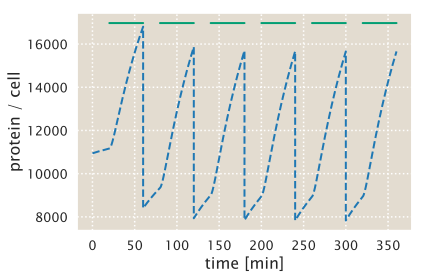

In [19]:
# Define color
colors = np.flip(sns.color_palette('Paired', n_colors=2), axis=0)

# Plot mean mRNA as solid line
plt.plot(df.time / 60, p_mean, label=r'$\left\langle m \right\rangle$', 
         color=colors[0], linestyle='--')

# Group data frame by cell cycle
df_group = df.groupby('cycle')
# Loop through cycles
for i, (group, data) in enumerate(df_group):
    # Find index for two-promoter state
    idx = data.state == 'double'
    # Indicate states with two promoters
    plt.plot(data.loc[idx, 'time'] / 60, 
             np.array([p_mean.max() * 1.01] * len(data))[idx],
             color='g')

# Label plot
plt.xlabel('time [min]')
_ = plt.ylabel('protein / cell')

## Three-state promoter

Let's now include the regulation given by the repressor. For this we change to the three-state promoter that includes two new parameters $\kron$ and $\kroff$. The fold-change for this three-state promoter would be of the form
$$
\foldchange = 
{ f \cdot \ee{m(R \neq 0)}_1 + (1 - f) \cdot \ee{m(R \neq 0)}_2
\over
f \cdot \ee{m(R = 0)}_1 + (1 - f) \cdot \ee{m(R = 0)}_2}.
$$

If we take the measured repressor copy number as an effective parameter that doesn't change when the cells have one vs two promoters then it can be shown that the fold-change can be simplified to
$$
\foldchange = \left( 1 + {\kron \over \kroff} \left( {\kpon \over \kpon + \kpoff} \right) \right)^{-1}.
$$

Let's define all the necessary parameters for this three-state promoter.

In [21]:
# Define mRNA rate
# http://bionumbers.hms.harvard.edu/bionumber.aspx?id=105717&ver=3&trm=lacZ%20mRNA%20lifetime&org=
gm = 1 / (3 * 60)

# Load the flat-chain
with open('../../data/mcmc/lacUV5_constitutive_mRNA_double.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()

# Generate a Pandas Data Frame with the mcmc chain
index = ['kp_on', 'kp_off', 'rm']

# Generate a data frame out of the MCMC chains
df_mcmc = pd.DataFrame(gauss_flatchain, columns=index)

# rerbsine the index with the new entries
index = df_mcmc.columns

# map value of the parameters
max_idx = np.argmax(gauss_flatlnprobability, axis=0)
kp_on, kp_off, rm = df_mcmc.iloc[max_idx, :] * gm

Let's compute the moments for the $R = 260$ strains and the O2 operator in the absence of inducer.

In [22]:
# Define repressor specific parameters

# Diffusion limited rate
ko = 2.7E-3 # s**-1 nmol**-1

# repressors per cell
rep = 260

# repressor-DNA binding energy
eRA = -13.9 # kBT

# Number of non-specific binding sites in thermodynamic model
Nns = 4.6E6

# Cell volume
Vcell = 2.15 # fL

# MWC induction parameters
ka = 139 # µM
ki = 0.53 # µM
epsilon = 4.5 # kBT

# Calculate the repressor on rate including the MWC model
kr_on = ko * rep * chann_cap.p_act(0, ka, ki, epsilon) 
    
# Compute the repressor off-rate based on the on-rate and 
# the binding energy
kr_off = chann_cap.kr_off_fun(eRA, ko, kp_on, kp_off, Nns, Vcell)

Now we will define the promoter state transition matrix $\mathbf{K}$, the mRNA production matrix $\mathbf{R}_m$, the mRNA degradation matrix $\mathbf{\Gamma}_m$, the protein production matrix $\mathbf{R}_p$, and the protein degradation matrix $\mathbf{\Gamma}_p$.

In [23]:
# Define the rate constant matrix
Km_reg = np.array([[-kp_off, kp_on, 0], 
                   [kp_off, -(kp_on + kr_on), kr_off],
                   [0, kr_on, -kr_off]])

# Define the production matrix
Rm_reg = np.array([[rm, 0, 0],
                   [0, 0, 0],
                   [0, 0, 0]])
# Define the degradation matrix
Gm_reg = np.array([[gm, 0, 0],
                   [0, gm, 0],
                   [0, 0, gm]])

Now we are ready to test the three-state model. Let's define the initial conditions.

In [24]:
# Define time on which to perform integration
t = np.linspace(0, 100 * 60, 301)

# Define initial conditions
m0_init = [0.3, 0.3, 0.4]
m1_init = [0, 0, 0]
m2_init = [0, 0, 0]
m3_init = [0, 0, 0]

# Numerically integrate equations
m_init = sp.integrate.odeint(dmdt,
                             m0_init + m1_init + m2_init + m3_init,
                             t, 
                             args=(Km_reg, Rm_reg, Gm_reg))

m_init = m_init[-1, :]

Let's now define the necesary inputs and run the numerical integration for several cell cycles.

In [25]:
# Define time for single-promoter state
t_single = 60 * 1 / 3 * 60 # sec
# Define time for two-promoter state
t_double = 60 * 2 / 3 * 60 # sec
# Define number of cell cycles
n_cycles = 3

# Integrate moment equations
df = dmdt_cycles(m_init, t_single, t_double, n_cycles,
                 Km_reg, Rm_reg, Gm_reg, states=['P', 'E', 'R'])

df_m_reg = df

Now let's plot the first moment $\pm$ standard deviation.

In [26]:
# Extract index for first and second moment
first_mom_names = [x for x in df.columns if 'm1' in x]
second_mom_names = [x for x in df.columns if 'm2' in x]

# Compute the mean mRNA copy number
m_mean = df.loc[:, first_mom_names].sum(axis=1)

# Compute the variance
m_second = df.loc[:, second_mom_names].sum(axis=1)
m_var = (m_second - m_mean**2)

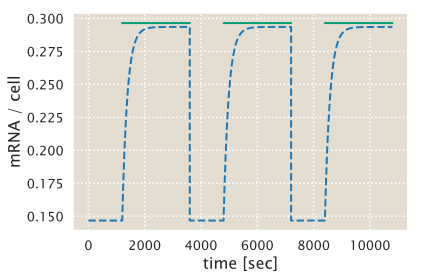

In [28]:
# Define color
colors = np.flip(sns.color_palette('Paired', n_colors=2), axis=0)

# Plot mean mRNA as solid line
plt.plot(df.time, m_mean, label=r'$\left\langle m \right\rangle$', 
         color=colors[0], linestyle='--')

# Group data frame by cell cycle
df_group = df.groupby('cycle')
# Loop through cycles
for i, (group, data) in enumerate(df_group):
    # Find index for two-promoter state
    idx = data.state == 'double'
    # Indicate states with two promoters
    plt.plot(data.loc[idx, 'time'], 
             np.array([(m_mean).max() * 1.01] * len(data))[idx],
             color='g')

# Label plot
plt.xlabel('time [sec]')
_ = plt.ylabel('mRNA / cell')

The average decreases significantly compared to the unregulated case. Now we need to check that the decrement follows what we would expect from the equilibrium model.

### LacI titration

To confirm that the determination of the $\kron$ parameter reproduces the thermodynamic predictions let's compute the fold-change for several repressor copy numbers and several operators.

In [29]:
# Compute mean repressor copy number for the unregulated promoter
# Keep only last cycle
df = df_m_unreg[df_m_unreg['cycle'] == df_m_unreg['cycle'].max()]
    
# Extract index for first and second moment
first_mom_names = [x for x in df.columns if 'm1' in x]

# Compute the mean mRNA copy number
m_mean_unreg = df.loc[:, first_mom_names].sum(axis=1).mean()

# Define repressor copy number list
rep_array = [22, 60, 124, 260, 1220, 1740] # repressors per cell

# Define energies
operators = ['Oid', 'O1', 'O2', 'O3']
energies = [-17, -15.3, -13.9, -9.7]

# Initialize data frame to save fold-changes
names = ['operator', 'energy', 'repressors', 'mean_m_reg', 'mean_m_unreg', 
         'fold_change']
df_fc_m = pd.DataFrame(columns=names)

# Loop through operators
for j, en in enumerate(energies):
    # Define binding energy
    eRA = en
    # Loop through repressor copy numbers
    for i, rep in enumerate(rep_array):
        # Calculate the repressor on rate including the MWC model
        kr_on = ko * rep * chann_cap.p_act(0, ka, ki, epsilon) 

        # Compute the repressor off-rate based on the on-rate and 
        # the binding energy
        kr_off = chann_cap.kr_off_fun(eRA, ko, kp_on, kp_off, Nns, Vcell)

        # Define the rate constant matrix
        Km_reg = np.array([[-kp_off, kp_on, 0], 
                           [kp_off, -(kp_on + kr_on), kr_off],
                           [0, kr_on, -kr_off]])

        # Define initial conditions
        m0_init = [0.3, 0.3, 0.4]
        m1_init = [0, 0, 0]
        m2_init = [0, 0, 0]
        m3_init = [0, 0, 0]

        # Numerically integrate equations
        m_init = sp.integrate.odeint(dmdt,
                                     m0_init + m1_init + m2_init + m3_init,
                                     t, 
                                     args=(Km_reg, Rm_reg, Gm_reg))

        m_init = m_init[-1, :]

        # Integrate moment equations
        df = dmdt_cycles(m_init, t_single, t_double, n_cycles,
                     Km_reg, Rm_reg, Gm_reg, states=['P', 'E', 'R'])

        # Keep only last cycle
        df = df[df['cycle'] == df['cycle'].max()]

        # Extract index for first and second moment
        first_mom_names = [x for x in df.columns if 'm1' in x]

        # Compute the mean mRNA copy number
        m_mean = df.loc[:, first_mom_names].sum(axis=1).mean()

        # Compute the fold-change
        fold_change = m_mean / m_mean_unreg
        
        series = pd.Series([operators[j], energies[j], rep, m_mean,
                            m_mean_unreg, fold_change],
                            index=names)
        
        df_fc_m = df_fc_m.append(series, ignore_index=True)

In [30]:
df_fc_m.head()

,operator,energy,repressors,mean_m_reg,mean_m_unreg,fold_change
0,Oid,-17,22,0.114940,17.117908,0.006715
1,Oid,-17,60,0.042325,17.117908,0.002473
2,Oid,-17,124,0.020506,17.117908,0.001198
3,Oid,-17,260,0.009786,17.117908,0.000572
4,Oid,-17,1220,0.002086,17.117908,0.000122


We can visualize these results by ploting the fold-change in gene expression as a function of repressor copy number in a log-log plot.

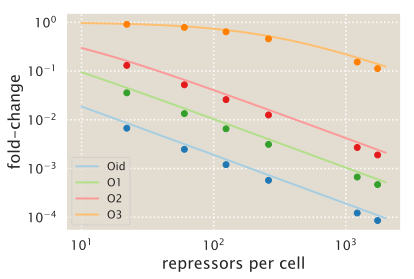

In [31]:
# Define range of repressors for which compute the thermo fold-change
r_array = np.logspace(1, np.log10(2000), 50)

# Group data frame by operator
df_group = df_fc_m.groupby('energy')

# Define colors
colors = sns.color_palette('Paired', n_colors=len(df_group) * 2)

# Loop through operator
for i, (group, data) in enumerate(df_group):
    # Compute thermo fold-change
    fold_change_thermo = (1 + r_array / Nns * np.exp(- group))**-1

    # Plot thermodynamic fold-change prediction
    plt.plot(r_array, fold_change_thermo, label=data.operator.unique()[0], 
             color=colors[i * 2])
    
    # Plot kinetic model fold-change prediction
    plt.plot(data.repressors.values, data.fold_change.values, lw=0, marker='o', 
             color=colors[(i * 2) + 1], label='')

# Change scale to log
plt.xscale('log')
plt.yscale('log')

# Label axis
plt.xlabel('repressors per cell')
plt.ylabel('fold-change')

# Set legend
plt.legend()

The small deviations from the kinetic and the thermodynamic picture come from the fact that the parameters as determined assume that the mRNA reaches steady state for both the single- and the double-promoter state. Factors such as the transients before the mRNA reaches steady state and the fact that the repressor copy number should be different between the single- and the double-promoter state gives these small deviations. But as a firts approximation we can work with this.

Let's now investigate if the same conclusions are reached at the protein level.

### Protein fold-change

To confirm that the kinetic picture also reproduces what we expect from the equilibrium model at the protein level let's repeat the same fold-change computation but using the mean protein level $\ee{p}$ rather than the mRNA level.

First we define the RNAP related parameters.

In [32]:
# Define mRNA rate
# http://bionumbers.hms.harvard.edu/bionumber.aspx?id=105717&ver=3&trm=lacZ%20mRNA%20lifetime&org=
gm = 1 / (3 * 60)

# Load the flat-chain
with open('../../data/mcmc/lacUV5_constitutive_mRNA_double.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()

# Generate a Pandas Data Frame with the mcmc chain
index = ['kp_on', 'kp_off', 'rm']

# Generate a data frame out of the MCMC chains
df_mcmc = pd.DataFrame(gauss_flatchain, columns=index)

# rerbsine the index with the new entries
index = df_mcmc.columns

# map value of the parameters
max_idx = np.argmax(gauss_flatlnprobability, axis=0)
kp_on, kp_off, rm = df_mcmc.iloc[max_idx, :] * gm

# Define protein production and degradatino rates
gp = 1 / 60**2 # sec^-1
rp = 1000 * gp # sec^-1

We now define the repressor specific parameters such as the diffusion limited rate $k_o$, the number of repressors and the repressor-DNA equilibrium binding energy to then compute the repressor kinetic parameters $\kron$ and $\kroff$.

In [33]:
# Define repressor specific parameters

# Diffusion limited rate
ko = 2.7E-3 # s**-1 nmol**-1

# repressors per cell
rep = 260

# repressor-DNA binding energy
eRA = -13.9 # kBT

# Number of non-specific binding sites in thermodynamic model
Nns = 4.6E6

# Cell volume
Vcell = 2.15 # fL

# MWC induction parameters
ka = 139 # µM
ki = 0.53 # µM
epsilon = 4.5 # kBT

# Calculate the repressor on rate including the MWC model
kr_on = ko * rep * chann_cap.p_act(0, ka, ki, epsilon) 
    
# Compute the repressor off-rate based on the on-rate and 
# the binding energy
kr_off = chann_cap.kr_off_fun(eRA, ko, kp_on, kp_off, Nns, Vcell)

Now let's define the corresponding matrices for the three-state model.

In [34]:
# Define the rate constant matrix
Km_reg = np.array([[-kp_off, kp_on, 0], 
                   [kp_off, -(kp_on + kr_on), kr_off],
                   [0, kr_on, -kr_off]])

# Define the production matrix
Rm_reg = np.array([[rm, 0, 0],
                   [0, 0, 0],
                   [0, 0, 0]])
# Define the degradation matrix
Gm_reg = np.array([[gm, 0, 0],
                   [0, gm, 0],
                   [0, 0, gm]])

# Define the production matrix
Rp_reg = np.array([[rp, 0, 0],
                   [0, rp, 0],
                   [0, 0, rp]])

# Define the production matrix
Gp_reg = np.array([[gp, 0, 0],
                   [0, gp, 0],
                   [0, 0, gp]])

As before we compute the initial conditions of the simulations by integrating the equations for a long time using the one-promoter state parameters.

In [35]:
# Define time on which to perform integration
t = np.linspace(0, 1000 * 60, 1000)

# Define initial conditions
m0_init = [0.3, 0.3, 0.4]
m1_init = [0, 0, 0]
m2_init = [0, 0, 0]
m3_init = [0, 0, 0]
p1_init = [0, 0, 0]
mp_init = [0, 0, 0]
p2_init = [0, 0, 0]
m2p_init = [0, 0, 0]
mp2_init = [0, 0, 0]
p3_init = [0, 0, 0]

# Numerically integrate equations
mp_sol = sp.integrate.odeint(dpdt, m0_init + m1_init + m2_init + m3_init +
                                   p1_init + mp_init + p2_init + m2p_init +
                                   mp2_init + p3_init, t,
                             args=(Km_reg, Rm_reg, Gm_reg, Rp_reg, Gp_reg))

# Keep only the last point as the initial condition
mp_init = mp_sol[-1, :]

We now define the times that cells spend with one and two copies of the promoter and perform the integration for several cell cycles.

In [36]:
# Define time for single-promoter state
t_single = 60 * 1 / 3 * 60 # sec
# Define time for two-promoter state
t_double = 60 * 2 / 3 * 60 # sec
# Define number of cell cycles
n_cycles = 4

# Integrate moment equations
df = dpdt_cycles(mp_init, t_single, t_double, n_cycles, 
                 Km_reg, Rm_reg, Gm_reg,
                 Rp_reg, Gp_reg, states=['P', 'E', 'R'])

# Save result as extra data frame with different name
df_p_reg = df

We now extract the first moment.

In [37]:
# Extract index for first moment
first_mom_names = [x for x in df.columns if 'm0p1' in x]

# Compute the mean mRNA copy number
p_mean = df.loc[:, first_mom_names].sum(axis=1)

And now we plot this mean protein copy number as a function of time.

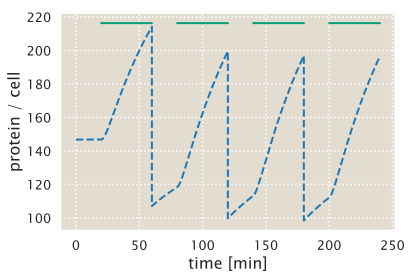

In [38]:
# Define color
colors = np.flip(sns.color_palette('Paired', n_colors=2), axis=0)

# Plot mean mRNA as solid line
plt.plot(df.time / 60, p_mean, label=r'$\left\langle m \right\rangle$', 
         color=colors[0], linestyle='--')

# Group data frame by cell cycle
df_group = df.groupby('cycle')
# Loop through cycles
for i, (group, data) in enumerate(df_group):
    # Find index for two-promoter state
    idx = data.state == 'double'
    # Indicate states with two promoters
    plt.plot(data.loc[idx, 'time'] / 60, 
             np.array([p_mean.max() * 1.01] * len(data))[idx],
             color='g')

# Label plot
plt.xlabel('time [min]')
_ = plt.ylabel('protein / cell')

Again we see that the mean number of proteins per cell decreases significantly, we now need to check of this decrement follows what we expect from the equilibrium picture.

In [39]:
# Compute mean repressor copy number for the unregulated promoter
# Keep only last cycle
df = df_p_unreg[df_p_unreg['cycle'] == df_p_unreg['cycle'].max()]
    
# Extract index for first and second moment
first_mom_names = [x for x in df.columns if 'm0p1' in x]

# Compute the mean mRNA copy number
p_mean_unreg = df.loc[:, first_mom_names].sum(axis=1).mean()

# Define repressor copy number list
rep_array = [22, 60, 124, 260, 1220, 1740] # repressors per cell

# Define energies
operators = ['Oid', 'O1', 'O2', 'O3']
energies = [-17, -15.3, -13.9, -9.7]

# Initialize data frame to save fold-changes
names = ['operator', 'energy', 'repressors',
         'mean_m_reg', 'mean_m_unreg', 'fold_change_m',
         'mean_p_reg', 'mean_p_unreg', 'fold_change_p']
df_fc_p = pd.DataFrame(columns=names)

# Loop through operators
for j, en in enumerate(energies):
    # Define binding energy
    eRA = en
    # Loop through repressor copy numbers
    for i, rep in enumerate(rep_array):
        # Calculate the repressor on rate including the MWC model
        kr_on = ko * rep * chann_cap.p_act(0, ka, ki, epsilon) 

        # Compute the repressor off-rate based on the on-rate and 
        # the binding energy
        kr_off = chann_cap.kr_off_fun(eRA, ko, kp_on, kp_off, Nns, Vcell)

        # Define the rate constant matrix
        Km_reg = np.array([[-kp_off, kp_on, 0], 
                           [kp_off, -(kp_on + kr_on), kr_off],
                           [0, kr_on, -kr_off]])

        # Define initial conditions
        m0_init = [0.3, 0.3, 0.4]
        m1_init = [0, 0, 0]
        m2_init = [0, 0, 0]
        m3_init = [0, 0, 0]
        p1_init = [0, 0, 0]
        mp_init = [0, 0, 0]
        p2_init = [0, 0, 0]
        m2p_init = [0, 0, 0]
        mp2_init = [0, 0, 0]
        p3_init = [0, 0, 0]

        # Numerically integrate equations
        m_init = sp.integrate.odeint(dpdt, 
                                     m0_init + m1_init + m2_init + m3_init +
                                     p1_init + mp_init + p2_init + m2p_init +
                                     mp2_init + p3_init,
                                     t, 
                                     args=(Km_reg, Rm_reg, Gm_reg,
                                           Rp_reg, Gp_reg))
        # Keep last time point as initial condition
        m_init = m_init[-1, :]

        # Integrate moment equations
        df = dpdt_cycles(m_init, t_single, t_double, n_cycles,
                         Km_reg, Rm_reg, Gm_reg, Rp_reg, Gp_reg,
                         states=['P', 'E', 'R'])

        # Keep only last cycle
        df = df[df['cycle'] == df['cycle'].max()]

        # Extract index for first moment
        first_mom_names_m = [x for x in df.columns if 'm1p0' in x]
        first_mom_names_p = [x for x in df.columns if 'm0p1' in x]

        # Compute the mean mRNA copy number
        m_mean = df.loc[:, first_mom_names_m].sum(axis=1).mean()
        p_mean = df.loc[:, first_mom_names_p].sum(axis=1).mean()

        # Compute the fold-change
        fold_change_m = m_mean / m_mean_unreg
        fold_change_p = p_mean / p_mean_unreg
        
        # Save results into series in order to append it to data frame
        series = pd.Series([operators[j], energies[j], rep, 
                            m_mean, m_mean_unreg, fold_change_m,
                            p_mean, p_mean_unreg, fold_change_p],
                           index=names)
        
        df_fc_p = df_fc_p.append(series, ignore_index=True)

In [40]:
df_fc_p.head()

,operator,energy,repressors,mean_m_reg,mean_m_unreg,fold_change_m,mean_p_reg,mean_p_unreg,fold_change_p
0,Oid,-17,22,0.114940,17.117908,0.006715,70.102581,10424.236248,0.006725
1,Oid,-17,60,0.042325,17.117908,0.002473,25.814057,10424.236248,0.002476
2,Oid,-17,124,0.020506,17.117908,0.001198,12.506633,10424.236248,0.001200
3,Oid,-17,260,0.009786,17.117908,0.000572,5.968442,10424.236248,0.000573
4,Oid,-17,1220,0.002086,17.117908,0.000122,1.272535,10424.236248,0.000122


Let's again plot the fold-change as a function of repressor copy number in a log-log plot.

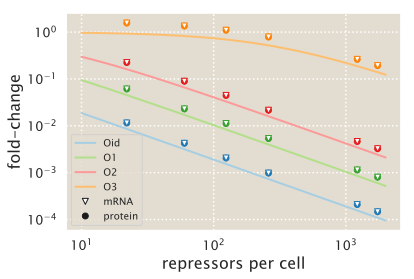

In [67]:
# Define range of repressors for which compute the thermo fold-change
r_array = np.logspace(1, np.log10(2000), 50)

# Group data frame by operator
df_group = df_fc_p.groupby('energy')

# Define colors
colors = sns.color_palette('Paired', n_colors=len(df_group) * 2)
# Loop through operator
for i, (group, data) in enumerate(df_group):
    # Compute thermo fold-change
    fold_change_thermo = (1 + r_array / Nns * np.exp(- group))**-1

    # Plot thermodynamic fold-change prediction
    plt.plot(r_array, fold_change_thermo, label=data.operator.unique()[0],
             color=colors[i * 2])
    # Plot the kinetic fold-change prediciton
    # Protein
    plt.plot(data.repressors.values, data.fold_change_p.values, lw=0, marker='o', 
             color=colors[(i * 2) + 1], label='')
    # mRNA
    plt.plot(data.repressors.values, data.fold_change_m.values, lw=0, marker='v', 
             markeredgecolor=colors[(i * 2) + 1], markeredgewidth=1,
             markerfacecolor='w', label='')

# Generate labels for mRNA and protein
plt.plot([], [], lw=0, marker='v', 
         markeredgecolor='k', markeredgewidth=1,
         markerfacecolor='w', label='mRNA')
plt.plot([], [], lw=0, marker='o', 
         color='k', label='protein')

# Change scale to log
plt.xscale('log')
plt.yscale('log')

# Label axis
plt.xlabel('repressors per cell')
plt.ylabel('fold-change')

# Set legend
plt.legend(fontsize=10)

The same systematic deviation is found at the protein level. This again is most likely caused by the fact the the protein doesn't reach steady state and we do not adjust the repressor copy number between the single- and the double-promoter state.

## IPTG titration 

Now that we know that the rates are able to reproduce the equilibrium picture of the LacI titration (up to a systematic deviation) let's complete the analysis of the equivalence between both frameworks by including the effect of the inducer.

For this analysis we will keep the operator fix and vary both the repressor copy number and the IPTG concentration. Let's first define again the necessary parameters.

In [42]:
# Define mRNA rate
# http://bionumbers.hms.harvard.edu/bionumber.aspx?id=105717&ver=3&trm=lacZ%20mRNA%20lifetime&org=
gm = 1 / (3 * 60)

# Load the flat-chain
with open('../../data/mcmc/lacUV5_constitutive_mRNA_double.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()

# Generate a Pandas Data Frame with the mcmc chain
index = ['kp_on', 'kp_off', 'rm']

# Generate a data frame out of the MCMC chains
df_mcmc = pd.DataFrame(gauss_flatchain, columns=index)

# rerbsine the index with the new entries
index = df_mcmc.columns

# map value of the parameters
max_idx = np.argmax(gauss_flatlnprobability, axis=0)
kp_on, kp_off, rm = df_mcmc.iloc[max_idx, :] * gm

# Define repressor specific parameters

# Diffusion limited rate
ko = 2.7E-3 # s**-1 nmol**-1

# repressor-DNA binding energy
op = 'O2'
eRA = -13.9 # kBT

# Number of non-specific binding sites in thermodynamic model
Nns = 4.6E6

# Cell volume
Vcell = 2.15 # fL

# MWC induction parameters
ka = 139 # µM
ki = 0.53 # µM
epsilon = 4.5 # kBT

Let's now run the dynamics for several cell cycles while varying the inducer concentration.

In [43]:
# Compute mean repressor copy number for the unregulated promoter
# Keep only last cycle
df = df_p_unreg[df_p_unreg['cycle'] == df_p_unreg['cycle'].max()]
    
# Extract index for first and second moment
first_mom_names = [x for x in df.columns if 'm0p1' in x]

# Compute the mean mRNA copy number
p_mean_unreg = df.loc[:, first_mom_names].sum(axis=1).mean()

# Define repressor copy number list
rep_array = [22, 60, 124, 260, 1220, 1740] # repressors per cell

# Define IPTG concentrations
iptg_array = [0, 0.1, 5, 10, 25, 25, 50, 75, 100, 500, 1000] # µM

# Initialize data frame to save fold-changes
names = ['operator', 'energy', 'repressors', 'iptg_uM',
         'mean_m_reg', 'mean_m_unreg', 'fold_change_m',
         'mean_p_reg', 'mean_p_unreg', 'fold_change_p']
df_fc_iptg = pd.DataFrame(columns=names)

# Loop through operators
for j, iptg in enumerate(iptg_array):
    print(iptg)
    # Loop through repressor copy numbers
    for i, rep in enumerate(rep_array):
        # Calculate the repressor on rate including the MWC model
        kr_on = ko * rep * chann_cap.p_act(iptg, ka, ki, epsilon) 

        # Compute the repressor off-rate based on the on-rate and 
        # the binding energy
        kr_off = chann_cap.kr_off_fun(eRA, ko, kp_on, kp_off, Nns, Vcell)

        # Define the rate constant matrix
        Km_reg = np.array([[-kp_off, kp_on, 0], 
                           [kp_off, -(kp_on + kr_on), kr_off],
                           [0, kr_on, -kr_off]])

        # Define initial conditions
        m0_init = [0.3, 0.3, 0.4]
        m1_init = [0, 0, 0]
        m2_init = [0, 0, 0]
        m3_init = [0, 0, 0]
        p1_init = [0, 0, 0]
        mp_init = [0, 0, 0]
        p2_init = [0, 0, 0]
        m2p_init = [0, 0, 0]
        mp2_init = [0, 0, 0]
        p3_init = [0, 0, 0]

        # Numerically integrate equations
        m_init = sp.integrate.odeint(dpdt, 
                                     m0_init + m1_init + m2_init + m3_init +
                                     p1_init + mp_init + p2_init + m2p_init +
                                     mp2_init + p3_init,
                                     t, 
                                     args=(Km_reg, Rm_reg, Gm_reg,
                                           Rp_reg, Gp_reg))
        # Keep last time point as initial condition
        m_init = m_init[-1, :]

        # Integrate moment equations
        df = dpdt_cycles(m_init, t_single, t_double, n_cycles,
                         Km_reg, Rm_reg, Gm_reg, Rp_reg, Gp_reg,
                         states=['P', 'E', 'R'])

        # Keep only last cycle
        df = df[df['cycle'] == df['cycle'].max()]

        # Extract index for first moment
        first_mom_names_m = [x for x in df.columns if 'm1p0' in x]
        first_mom_names_p = [x for x in df.columns if 'm0p1' in x]

        # Compute the mean mRNA copy number
        m_mean = df.loc[:, first_mom_names_m].sum(axis=1).mean()
        p_mean = df.loc[:, first_mom_names_p].sum(axis=1).mean()

        # Compute the fold-change
        fold_change_m = m_mean / m_mean_unreg
        fold_change_p = p_mean / p_mean_unreg
        
        # Save results into series in order to append it to data frame
        series = pd.Series([op, eRA, rep, iptg,
                            m_mean, m_mean_unreg, fold_change_m,
                            p_mean, p_mean_unreg, fold_change_p],
                           index=names)
        
        df_fc_iptg = df_fc_iptg.append(series, ignore_index=True)

0
0.1
5
10
25
25
50
75
100
500
1000


In [44]:
df_fc_iptg.head()

,operator,energy,repressors,iptg_uM,mean_m_reg,mean_m_unreg,fold_change_m,mean_p_reg,mean_p_unreg,fold_change_p
0,O2,-13.9,22,0,2.233528,17.117908,0.130479,1362.237808,10424.236248,0.130680
1,O2,-13.9,60,0,0.892733,17.117908,0.052152,544.481344,10424.236248,0.052232
2,O2,-13.9,124,0,0.443916,17.117908,0.025933,270.746437,10424.236248,0.025973
3,O2,-13.9,260,0,0.214625,17.117908,0.012538,130.900879,10424.236248,0.012557
4,O2,-13.9,1220,0,0.046196,17.117908,0.002699,28.174882,10424.236248,0.002703


Let's plot this IPTG titration

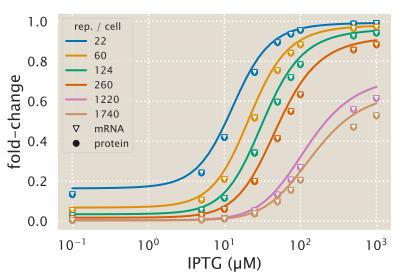

In [45]:
# Define IPTG range to compute thermodynamic fold-change
iptg = np.logspace(-1, 3, 50)

# Group data frame by repressor copy number
df_group = df_fc_iptg.groupby('repressors')

# Define colors
colors = sns.color_palette('colorblind', n_colors=len(df_group))

# Loop through each of the repressor copy numbers
for i, (rep, data) in enumerate(df_group):
    # Compute thermodynamic fold-change
    fc_thermo = (1 + rep / Nns * chann_cap.p_act(iptg, ka, ki, epsilon) *
                 np.exp(- data.energy.unique()[0]))**-1
    
    # Plot thermodynamic fold-change prediction
    plt.plot(iptg, fc_thermo, label=str(rep), color=colors[i])
    
    # Plot the kinetic fold-change prediciton
    # Protein
    plt.plot(data.iptg_uM.values, data.fold_change_p.values, lw=0, marker='o', 
             color=colors[i], label='')
    # mRNA
    plt.plot(data.iptg_uM.values, data.fold_change_m.values, lw=0, marker='v', 
             markeredgecolor=colors[i], markeredgewidth=1,
             markerfacecolor='w', label='')

# Generate labels for mRNA and protein
plt.plot([], [], lw=0, marker='v', 
         markeredgecolor='k', markeredgewidth=1,
         markerfacecolor='w', label='mRNA')
plt.plot([], [], lw=0, marker='o', 
         color='k', label='protein')
    
# Change scale to log
plt.xscale('log')

# Label axis
plt.xlabel('IPTG (µM)')
plt.ylabel('fold-change')

# Set legend
_ = plt.legend(title='rep. / cell', fontsize=10)

This again gives the same small systematic deviation, but it is within the error of what we could determine experimentally. So we are ready to use these dynamics with cell division to see how this affects the information processing capacity of cells.

## Systematic moment computation

Now that we confirmed that these parameters can reproduce the equilibrium picture let's systematically obtain average moments for varying repressor copy numbers, operators and inducer concentrations that later on we will use to compute the maximum entropy approximation of the distribution.

We will generate and export a tidy data frame containing all moments. First let's list all the parameters that will remain fixed.

In [43]:
# Define mRNA rate
# http://bionumbers.hms.harvard.edu/bionumber.aspx?id=105717&ver=3&trm=lacZ%20mRNA%20lifetime&org=
gm = 1 / (3 * 60)

# Load the flat-chain
with open('../../data/mcmc/lacUV5_constitutive_mRNA_double.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()

# Generate a Pandas Data Frame with the mcmc chain
index = ['kp_on', 'kp_off', 'rm']

# Generate a data frame out of the MCMC chains
df_mcmc = pd.DataFrame(gauss_flatchain, columns=index)

# rerbsine the index with the new entries
index = df_mcmc.columns

# map value of the parameters
max_idx = np.argmax(gauss_flatlnprobability, axis=0)
kp_on, kp_off, rm = df_mcmc.iloc[max_idx, :] * gm

# Define protein production and degradatino rates
gp = 1 / 60**2 # sec^-1
rp = 1000 * gp # sec^-1

# Number of non-specific binding sites in thermodynamic model
Nns = 4.6E6

# Cell volume
Vcell = 2.15 # fL

# MWC induction parameters
ka = 139 # µM
ki = 0.53 # µM
epsilon = 4.5 # kBT

# Define time for single-promoter state
t_single = 60 * 1 / 3 * 60 # sec
# Define time for two-promoter state
t_double = 60 * 2 / 3 * 60 # sec
# Define number of cell cycles
n_cycles = 4

Now we define the matrices that won't change for all parameters given these parameter values

In [44]:
# Define the production matrix
Rm_reg = np.array([[rm, 0, 0],
                   [0, 0, 0],
                   [0, 0, 0]])
# Define the degradation matrix
Gm_reg = np.array([[gm, 0, 0],
                   [0, gm, 0],
                   [0, 0, gm]])

# Define the production matrix
Rp_reg = np.array([[rp, 0, 0],
                   [0, rp, 0],
                   [0, 0, rp]])

# Define the production matrix
Gp_reg = np.array([[gp, 0, 0],
                   [0, gp, 0],
                   [0, 0, gp]])

Let's now list the parameters that will be varied for the different strains.

In [45]:
# Define experimental concentrations in µM
inducer = [0, 0.1, 5, 10, 25, 50, 75, 100, 250, 500, 1000, 5000] # µM

# Define repressor copy numebers
repressors = np.logspace(0, np.log10(2000), 25)
repressors = np.unique(repressors.round(0))

# Include repressor copy numbers for experimentally available strains
rep = [0, 11, 30, 62, 130, 610, 870]
# Include repressor dimers into the list
rep = rep + [r * 2 for r in rep[1:]]
# Add them to list
repressors =  np.concatenate([repressors, rep])

# Define operators and energies
operators = ['O1', 'O2', 'O3']
energies = [-15.3, -13.9, -9.7]
op_dict = dict(zip(operators, energies))

Now given these parameters let's compute the moments, that will serve as constraints for the MaxEnt distribution.

In [52]:
# Define index of moments to be used in the computation
moments = [(1, 0), (2, 0), (3, 0),
           (0, 1), (1, 1), (0, 2),
           (2, 1), (1, 2), (0, 3)]

# Initialize data frame to save the lagrange multipliers.
names = ['operator', 'binding_energy', 'repressor', 'inducer_uM']
names = names + ['m' + str(m[0]) + 'p' + str(m[1]) for m in moments]         

# Initialize DataFrame to save constraints
df_constraints = pd.DataFrame([], columns=names)

compute_constraints = False
if compute_constraints:
    # Loop through operators
    for op in operators:
        print(op)
        eRA = op_dict[op]
        # Loop through repressor copy numbers
        for rep in repressors:
            # Loop through IPTG concentrations
            for iptg in inducer:
                # Calculate the repressor on rate including the MWC model
                kr_on = ko * rep * chann_cap.p_act(iptg, ka, ki, epsilon) 

                # Compute the repressor off-rate based on the on-rate and 
                # the binding energy
                kr_off = chann_cap.kr_off_fun(eRA, ko, kp_on, kp_off, Nns, Vcell)

                # Define the rate constant matrix
                Km_reg = np.array([[-kp_off, kp_on, 0], 
                                   [kp_off, -(kp_on + kr_on), kr_off],
                                   [0, kr_on, -kr_off]])

                # Define initial conditions
                m0_init = [0.3, 0.3, 0.4]
                m1_init = [0, 0, 0]
                m2_init = [0, 0, 0]
                m3_init = [0, 0, 0]
                p1_init = [0, 0, 0]
                mp_init = [0, 0, 0]
                p2_init = [0, 0, 0]
                m2p_init = [0, 0, 0]
                mp2_init = [0, 0, 0]
                p3_init = [0, 0, 0]

                # Define time on which to perform integration
                t = np.linspace(0, 100 * 60, 301)
                # Numerically integrate equations
                m_init = sp.integrate.odeint(dpdt, 
                                             m0_init + m1_init + m2_init + m3_init +
                                             p1_init + mp_init + p2_init + m2p_init +
                                             mp2_init + p3_init,
                                             t, 
                                             args=(Km_reg, Rm_reg, Gm_reg,
                                                   Rp_reg, Gp_reg))
                # Keep last time point as initial condition
                m_init = m_init[-1, :]

                # Integrate moment equations
                df = dpdt_cycles(m_init, t_single, t_double, n_cycles,
                                 Km_reg, Rm_reg, Gm_reg, Rp_reg, Gp_reg,
                                 n_steps=300,
                                 states=['P', 'E', 'R'])

                # Keep only last cycle
                df = df[df['cycle'] == df['cycle'].max()]

                # Initialize list to append moments
                moms = list()
                # Loop through moments computing the average moment
                for i, mom in enumerate(moments):
                    # Generate string that finds the moment
                    mom_name = 'm' + str(mom[0]) + 'p' + str(mom[1])
                    # List rows with moment
                    mom_bool = [x for x in df.columns if mom_name in x]
                    # Average moment and append it to list
                    moms.append(df.loc[:, mom_bool].sum(axis=1).mean())
                
                # Save results into series in order to append it to data frame
                series = pd.Series([op, eRA, rep, iptg] + moms,
                           index=names)
    
                # Append to DataFrame
                df_constraints = df_constraints.append(series, ignore_index=True)

                # Save progress at each step
                df_constraints.to_csv(datadir + 'MaxEnt_multi_promoter_cell_division_constraints.csv',
                          index=False)
                
df_constraints = pd.read_csv(datadir + 'MaxEnt_multi_promoter_cell_division_constraints.csv')
df_constraints.head()

,operator,binding_energy,repressor,inducer_uM,m1p0,m2p0,m3p0,m0p1,m1p1,m0p2,m2p1,m1p2,m0p3
0,O1,-15.3,1.0,0.0,7.679175,141.660828,3605.804867,4680.734834,44313.406816,3.054972e+07,8.973551e+05,3.258713e+08,2.259967e+11
1,O1,-15.3,1.0,0.1,7.698248,142.130724,3619.488596,4692.359750,44520.180483,3.069241e+07,9.022166e+05,3.280388e+08,2.275083e+11
2,O1,-15.3,1.0,5.0,10.803320,221.432374,5977.235910,6584.835844,83759.426215,5.779364e+07,1.861974e+06,8.035538e+08,5.606444e+11
3,O1,-15.3,1.0,10.0,13.603870,296.295301,8261.215167,8291.619138,128007.772321,8.839830e+07,2.998312e+06,1.457942e+09,1.022548e+12
4,O1,-15.3,1.0,25.0,16.088213,364.351704,10366.377796,9805.612742,173628.785154,1.199874e+08,4.203043e+06,2.229632e+09,1.570680e+12


### Comparing constraints with single-promoter model.

Let's take a look at how different the constraints are between a single promoter model and a multi-promoter model. First let's compare the first mRNA and protein moment. This we expect them to be quite similar.

/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


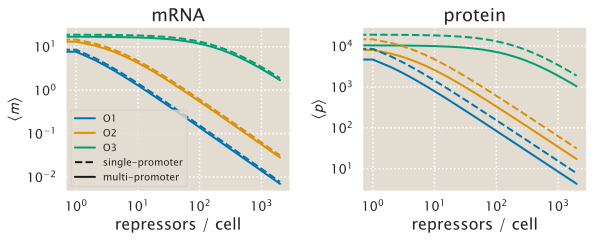

In [53]:
# Read constraints for the single promoter model
df_constraints_single = pd.read_csv(datadir +
                                    'MaxEnt_ss_constraints.csv')
df_constraints_single = df_constraints_single\
                        [df_constraints_single.operator != 'Oid']

# Group both
df_group = df_constraints.sort_values('repressor')\
          [df_constraints.inducer_uM == 0].groupby('operator')
df_single_group = df_constraints_single.sort_values('repressor')\
          [df_constraints_single.inducer_uM == 0].groupby('operator')

# Define colors for plot
colors = sns.color_palette('colorblind', n_colors=len(df_group))

# Initialize figure
fig, ax = plt.subplots(1, 2, figsize=(8.5, 3.5), sharey=False, sharex=True)

# Loop through the groups and plot protein first moment
for i, (group, data) in enumerate(df_group):
    ax[0].plot(data.repressor, data.m1p0, label=group, color=colors[i])
    ax[1].plot(data.repressor, data.m0p1, label=group, color=colors[i])

    
for i, (group, data) in enumerate(df_single_group):
    ax[0].plot(data.repressor, data.m1p0, color=colors[i],
             linestyle='--', label='')
    ax[1].plot(data.repressor, data.m0p1, color=colors[i],
             linestyle='--', label='')

# Generate legend for single vs double promoter
ax[0].plot([], [], color='k', linestyle='--', label='single-promoter')
ax[0].plot([], [], color='k', label='multi-promoter')

# Change plot scale
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_yscale('log')

# Label axis
ax[0].set_xlabel('repressors / cell')
ax[1].set_xlabel('repressors / cell')
ax[0].set_ylabel(r'$\left\langle m \right\rangle$')
ax[1].set_ylabel(r'$\left\langle p \right\rangle$')

# Set title
ax[0].set_title('mRNA')
ax[1].set_title('protein')

# Include legend
ax[0].legend(fontsize=10)
plt.tight_layout()

As expected the mRNA first moment are basically the same since given the fast degradation rate this molecule is basically at steady state for the most part during both phases in the multi-promoter case. For the protein we have that the multi promoter model has systematically less protein than the single promoter case. This is because since protein never reaches the steady state for the two-promoter case it doesn't have as much as one would expect from the steady state assumption.

#### Fano factor

Let's now look at the Fano-factor for both molecules. For this we expect the multi-promoter case to be larger since it is more noisy than the single promoter case.

/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


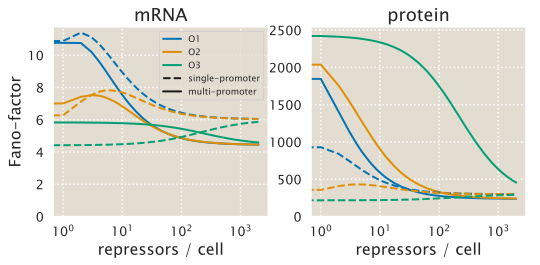

In [54]:
# Group both
df_group = df_constraints.sort_values('repressor')\
          [df_constraints.inducer_uM == 0].groupby('operator')
df_single_group = df_constraints_single.sort_values('repressor')\
          [df_constraints_single.inducer_uM == 0].groupby('operator')

# Define colors for plot
colors = sns.color_palette('colorblind', n_colors=len(df_group))

# Initialize figure
fig, ax = plt.subplots(1, 2, figsize=(8.5, 3.5), sharey=False, sharex=True)

# Loop through the groups and plot protein first moment
for i, (group, data) in enumerate(df_group):
    ax[0].plot(data.repressor, (data.m2p0 - data.m1p0**2) / data.m1p0, label=group, color=colors[i])
    ax[1].plot(data.repressor, (data.m0p2 - data.m0p1**2) / data.m0p1, label=group, color=colors[i])

    
for i, (group, data) in enumerate(df_single_group):
    ax[0].plot(data.repressor, (data.m2p0 - data.m1p0**2) / data.m1p0, color=colors[i],
             linestyle='--', label='')
    ax[1].plot(data.repressor, (data.m0p2 - data.m0p1**2) / data.m0p1, color=colors[i],
             linestyle='--', label='')

# Generate legend for single vs double promoter
ax[0].plot([], [], color='k', linestyle='--', label='single-promoter')
ax[0].plot([], [], color='k', label='multi-promoter')

# Change plot scale
ax[0].set_xscale('log')
ax[1].set_xscale('log')

# Set plot so that it shows where 0 in the y-axis is
ax[0].set_ylim(bottom=0)
ax[1].set_ylim(bottom=0)

# Label axis
ax[0].set_xlabel('repressors / cell')
ax[1].set_xlabel('repressors / cell')
ax[0].set_ylabel(r'Fano-factor')

# Set title
ax[0].set_title('mRNA')
ax[1].set_title('protein')

# Include legend
ax[0].legend(fontsize=9)

For the protein level we can see that as expected the multi-promoter model gives a much higher noise compared to the single-promoter model. Interestingly the mRNA shows a strange mixture of all kinds of behaviors which would require further analysis to fully understand what's going on there.

#### Skewness

Let's finally look at the skewness (related to the third moment) to see how much this moment changes relatively to the other moments.

The skweness is defined as
$$
\ee{\left( {X - \ee{X} \over \sigma_X} \right)^3} =
{\ee{X^3} - 3 \ee{X} \sigma_X^2 + 2 \ee{X}^3 \over \sigma_X^3},
$$
whre $\sigma_X$ is the standard deviation of variable $X$.

/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


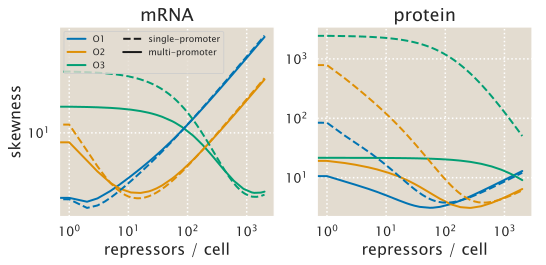

In [76]:
# Group both
df_group = df_constraints.sort_values('repressor')\
          [df_constraints.inducer_uM == 0].groupby('operator')
df_single_group = df_constraints_single.sort_values('repressor')\
          [df_constraints_single.inducer_uM == 0].groupby('operator')

# Define colors for plot
colors = sns.color_palette('colorblind', n_colors=len(df_group))

# Initialize figure
fig, ax = plt.subplots(1, 2, figsize=(8.5, 3.5), sharey=False, sharex=True)

# Loop through the groups and plot protein first moment
for i, (group, data) in enumerate(df_group):
    std = np.sqrt(data.m2p0 - data.m1p0**2)
    skewness = (data.m3p0 - 3 * data.m1p0 * std**2 + 2 * data.m1p0**3) / std**3
    ax[0].plot(data.repressor, skewness, label=group, color=colors[i])
    
    std = np.sqrt(data.m0p2 - data.m0p1**2)
    skewness = (data.m0p3 - 3 * data.m0p1 * std**2 + 2 * data.m0p1**3) / std**3
    ax[1].plot(data.repressor, skewness, label=group, color=colors[i])

    
for i, (group, data) in enumerate(df_single_group):
    std = np.sqrt(data.m2p0 - data.m1p0**2)
    skewness = (data.m3p0 - 3 * data.m1p0 * std**2 + 2 * data.m1p0**3) / std**3
    ax[0].plot(data.repressor, skewness, color=colors[i],
             linestyle='--', label='')
    
    std = np.sqrt(data.m0p2 - data.m0p1**2)
    skewness = (data.m0p3 - 3 * data.m0p1 * std**2 + 2 * data.m0p1**3) / std**3
    ax[1].plot(data.repressor, skewness, color=colors[i],
             linestyle='--', label='')

# Generate legend for single vs double promoter
ax[0].plot([], [], color='k', linestyle='--', label='single-promoter')
ax[0].plot([], [], color='k', label='multi-promoter')

# Change plot scale
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[1].set_xscale('log')
ax[1].set_yscale('log')



# Label axis
ax[0].set_xlabel('repressors / cell')
ax[1].set_xlabel('repressors / cell')
ax[0].set_ylabel(r'skewness')

# Set title
ax[0].set_title('mRNA')
ax[1].set_title('protein')

# Include legend
ax[0].legend(fontsize=9, ncol=2)

#### Computing the Maximum entropy distribution

Having computed the constraints let's go ahead and perform the MaxEnt optimization to obtain the Lagrange multipliers.

In [56]:
# Define index of moments to be used in the computation
moments = [(1, 0), (2, 0), (3, 0),
           (0, 1), (1, 1), (0, 2),
           (2, 1), (1, 2), (0, 3)]

# Define sample space
mRNA_space = np.arange(0, 50)
protein_space = np.arange(0, 2.5E4)
# Generate sample space as a list of pairs using itertools.
samplespace = list(itertools.product(mRNA_space, protein_space))

# Initialize matrix to save all the features that are fed to the
# maxentropy function
features = np.zeros([len(moments), len(samplespace)])

# Loop through constraints and compute features
for i, mom in enumerate(moments):
    features[i, :] = [chann_cap.feature_fn(x, mom) for x in samplespace]

In [57]:
# Initialize data frame to save the lagrange multipliers.
names = ['operator', 'binding_energy', 'repressor', 'inducer_uM']

names = names + ['lambda_m' + str(m[0]) + 'p' + str(m[1]) for m in moments]

df_maxEnt = pd.DataFrame([], columns=names)

# Define column names containing the constraints used to fit the distribution
constraints_names = ['m' + str(m[0]) + 'p' + str(m[1]) for m in moments]

fit_dist = False
if fit_dist:
    # Define function for parallel computation
    def maxEnt_parallel(idx, df):
        # Report on progress
        print('iteration: ',idx)
            
        # Extract constraints
        constraints = df.loc[constraints_names]
        
        # Perform MaxEnt computation
        Lagrange = chann_cap.MaxEnt_bretthorst(constraints, features, 
                                               algorithm='BFGS')
        # Save Lagrange multipliers into dataframe
        series = pd.Series(Lagrange, index=names[4::])
        
        # Add other features to series before appending to dataframe
        series = pd.concat([df.drop(constraints_names), series])
        
        return series
    
    # Run the function in parallel
    maxEnt_series = Parallel(n_jobs=6)(delayed(maxEnt_parallel)(idx, df)
                           for idx, df in df_constraints.iterrows())
    
    # Initialize data frame to save list of parameters
    df_maxEnt = pd.DataFrame([], columns=names)

    for s in maxEnt_series:
        df_maxEnt = df_maxEnt.append(s, ignore_index=True)

    df_maxEnt.to_csv(datadir +
                     'MaxEnt_ss_Lagrange_multipliers_cell_division.csv')
    
df_maxEnt = pd.read_csv(datadir +
                     'MaxEnt_ss_Lagrange_multipliers_cell_division.csv')
df_maxEnt.head()

,Unnamed: 0,operator,binding_energy,repressor,inducer_uM,lambda_m1p0,lambda_m2p0,lambda_m3p0,lambda_m0p1,lambda_m1p1,lambda_m0p2,lambda_m2p1,lambda_m1p2,lambda_m0p3
0,0,O1,-15.3,1.0,0.0,-0.323454,0.008610,-0.000103,-0.000744,0.000009,1.810040e-07,-3.068002e-07,1.259856e-09,-1.403338e-11
1,1,O1,-15.3,1.0,0.1,-0.322354,0.008562,-0.000102,-0.000744,0.000009,1.807587e-07,-3.055396e-07,1.257759e-09,-1.398496e-11
2,2,O1,-15.3,1.0,5.0,-0.156727,0.001419,-0.000011,-0.000780,0.000003,1.542632e-07,-1.786224e-07,9.315931e-10,-8.991766e-12
3,3,O1,-15.3,1.0,10.0,0.003130,-0.005491,0.000076,-0.000843,0.000001,1.431205e-07,-1.335204e-07,7.572052e-10,-6.939904e-12
4,4,O1,-15.3,1.0,25.0,0.204351,-0.014288,0.000185,-0.000923,0.000001,1.385683e-07,-1.173541e-07,6.356075e-10,-5.892872e-12


# Moment dynamics with cells exponentially distributed along cell cycle

As first discussed by Powell in 1956 populations of cells in a log-phase are exponentially distributed along the cell cycle. This distribution is of the form
$$
P(a) = (\ln 2) \cdot 2^{1 - a},
$$
where $a \in [0, 1]$ is the stage of the cell cycle, with $a = 0$ being the start of the cycle and $a = 1$ being the division.

We have previously inferred mRNA unregulated promoter parameters using this distribution. What it is left is to compute the mRNA and protein moments taken into account this distribution. To do so we will compute just as before the expected moments along the cell cycle where 1/3 of the time cells have one promoter and 2/3 they have two. This gives us continuous description of how we expect the moments to evole over time $\ee{n^x(t)}$, where $m \in \{ m, p\}$. The difference before is that in order to calculate the average over time of this time series we won't siimply take the mean over all the time points we compute; instead this time we will compute the time average as
$$
\ee{\ee{n^x(t)}}_t = \int_{\text{start cell cycle}}^{\text{end cell cycle}} \ee{n^x(t)} P(t) dt.
$$
What this equation is telling us is that we will weigh each of the time points by the probability that a cell in this log-phase culture is at a specific moment of the cell cycle. So in reality we can map time to the variable $a$ and integrate from 0 to 1 as
$$
\ee{\ee{n^x(t)}}_t = \int_0^1 \ee{n^x(a)} P(a) da.
$$

Let's go ahead and test this for the LacI titration exercise we did before.

First let's define the parameters.

In [48]:
# Define mRNA rate
# http://bionumbers.hms.harvard.edu/bionumber.aspx?id=105717&ver=3&trm=lacZ%20mRNA%20lifetime&org=
gm = 1 / (3 * 60)

# Load the flat-chain
with open('../../data/mcmc/lacUV5_constitutive_mRNA_double_expo.pkl',
          'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()

# Generate a Pandas Data Frame with the mcmc chain
index = ['kp_on', 'kp_off', 'rm']

# Generate a data frame out of the MCMC chains
df_mcmc = pd.DataFrame(gauss_flatchain, columns=index)

# rerbsine the index with the new entries
index = df_mcmc.columns

# map value of the parameters
max_idx = np.argmax(gauss_flatlnprobability, axis=0)
kp_on, kp_off, rm = df_mcmc.iloc[max_idx, :] * gm

# Define protein production and degradatino rates
gp = 1 / 60**2 # sec^-1
rp = 1000 * gp # sec^-1

Now we will define the state transition matrix $\mathbf{K}$, the mRNA production matrix $\mathbf{R}_m$, the mRNA degradation matrix $\mathbf{\Gamma}_m$, the protein production matrix $\mathbf{R}_p$, and the protein degradation matrix $\mathbf{\Gamma}_p$.

In [49]:
# Define the rate constant matrix
Km_unreg = np.array([[-kp_off, kp_on], 
                     [kp_off, -kp_on]])
# Define the mRNA production matrix
Rm_unreg = np.array([[rm, 0], 
                     [0, 0]])
# Define the mRNA degradation matrix
Gm_unreg = np.array([[gm, 0],
                     [0, gm]])

# Define the protein production matrix
Rp_unreg = np.array([[rp, 0], 
                     [0, rp]])
# Define the protein degradation matrix
Gp_unreg = np.array([[gp, 0],
                     [0, gp]])

Let's run the integration to compute the initial conditions for the simulation.

In [51]:
# Define time on which to perform integration
t = np.linspace(0, 10000, 501)

# Define initial conditions
m0_init = [0.5, 0.5]
m1_init = [0, 0]
m2_init = [0, 0]
m3_init = [0, 0]
p1_init = [0, 0]
mp_init = [0, 0]
p2_init = [0, 0]
m2p_init = [0, 0]
mp2_init = [0, 0]
p3_init = [0, 0]

# Solve equation
mp_sol = sp.integrate.odeint(dpdt,
                             m0_init + m1_init + m2_init + m3_init +
                             p1_init + mp_init + p2_init + m2p_init +
                             mp2_init + p3_init,
                             t,
                             args=(Km_unreg, Rm_unreg, Gm_unreg,
                                   Rp_unreg, Gp_unreg))


mp_init = mp_sol[-1, :]

Let's now define the necesary inputs and run the numerical integration for several cell cycles.

In [52]:
# Define time for single-promoter state
t_single = 60 * 1 / 3 * 60 # sec
# Define time for two-promoter state
t_double = 60 * 2 / 3 * 60 # sec
# Define number of cell cycles
n_cycles = 6

# Integrate moment equations
df = dpdt_cycles(mp_init, t_single, t_double, n_cycles, 
                 Km_unreg, Rm_unreg, Gm_unreg,
                 Rp_unreg, Gp_unreg, n_steps=5000, t_ss=10000)

df_p_unreg = df

Now we can implement the integration over the cell cycle for the first moment.

In [64]:
# Extract index for mRNA and protein first moment
first_mom_names_m = [x for x in df.columns if 'm1p0' in x]
first_mom_names_p = [x for x in df.columns if 'm0p1' in x]

# Extract the last cycle information
df_m_unreg_first = df_p_unreg.loc[df_p_unreg.cycle == df_p_unreg.cycle.max(),
                                  first_mom_names_m]
df_p_unreg_first = df_p_unreg.loc[df_p_unreg.cycle == df_p_unreg.cycle.max(),
                                  first_mom_names_p]

# Define array for integration
a_array = np.linspace(0, 1, len(df_m_unreg_first))
# Compute probability based on this array
p_a_array = np.log(2) * 2**(1 - a_array)

# Perform numerical integration
m_mean_unreg = sp.integrate.simps(df_m_unreg_first.sum(axis=1) * p_a_array,
                                  a_array)
p_mean_unreg = sp.integrate.simps(df_p_unreg_first.sum(axis=1) * p_a_array,
                                  a_array)

print('<m> = {:.2f}'.format(m_mean_unreg))
print('<p> = {:.2f}'.format(p_mean_unreg))

<m> = 14.42
<p> = 8914.71


Let's repeat these calculations systematically for the regulated case for different repressor cop ynumbers and different operators.

In [65]:
# Define repressor copy number list
rep_array = [22, 60, 124, 260, 1220, 1740] # repressors per cell

# Define energies
operators = ['Oid', 'O1', 'O2', 'O3']
energies = [-17, -15.3, -13.9, -9.7]

# Initialize data frame to save fold-changes
names = ['operator', 'energy', 'repressors',
         'mean_m_reg', 'mean_m_unreg', 'fold_change_m',
         'mean_p_reg', 'mean_p_unreg', 'fold_change_p']
df_fc_p = pd.DataFrame(columns=names)

# Loop through operators
for j, en in enumerate(energies):
    # Define binding energy
    eRA = en
    # Loop through repressor copy numbers
    for i, rep in enumerate(rep_array):
        # Calculate the repressor on rate including the MWC model
        kr_on = ko * rep * chann_cap.p_act(0, ka, ki, epsilon) 

        # Compute the repressor off-rate based on the on-rate and 
        # the binding energy
        kr_off = chann_cap.kr_off_fun(eRA, ko, kp_on, kp_off, Nns, Vcell)

        # Define the rate constant matrix
        Km_reg = np.array([[-kp_off, kp_on, 0], 
                           [kp_off, -(kp_on + kr_on), kr_off],
                           [0, kr_on, -kr_off]])

        # Define initial conditions
        m0_init = [0.3, 0.3, 0.4]
        m1_init = [0, 0, 0]
        m2_init = [0, 0, 0]
        m3_init = [0, 0, 0]
        p1_init = [0, 0, 0]
        mp_init = [0, 0, 0]
        p2_init = [0, 0, 0]
        m2p_init = [0, 0, 0]
        mp2_init = [0, 0, 0]
        p3_init = [0, 0, 0]

        # Numerically integrate equations
        m_init = sp.integrate.odeint(dpdt, 
                                     m0_init + m1_init + m2_init + m3_init +
                                     p1_init + mp_init + p2_init + m2p_init +
                                     mp2_init + p3_init,
                                     t, 
                                     args=(Km_reg, Rm_reg, Gm_reg,
                                           Rp_reg, Gp_reg))
        # Keep last time point as initial condition
        m_init = m_init[-1, :]

        # Integrate moment equations
        df = dpdt_cycles(m_init, t_single, t_double, n_cycles,
                         Km_reg, Rm_reg, Gm_reg, Rp_reg, Gp_reg,
                         states=['P', 'E', 'R'])

        # Keep only last cycle
        df = df[df['cycle'] == df['cycle'].max()]

        # Extract index for first moment
        first_mom_names_m = [x for x in df.columns if 'm1p0' in x]
        first_mom_names_p = [x for x in df.columns if 'm0p1' in x]

        
        # Extract index for mRNA and protein first moment
        first_mom_names_m = [x for x in df.columns if 'm1p0' in x]
        first_mom_names_p = [x for x in df.columns if 'm0p1' in x]

        # Extract the last cycle information
        df_m_reg_first = df.loc[:, first_mom_names_m]
        df_p_reg_first = df.loc[:, first_mom_names_p]

        # Define array for integration
        a_array = np.linspace(0, 1, len(df_m_reg_first))
        # Compute probability based on this array
        p_a_array = np.log(2) * 2**(1 - a_array)

        # Perform numerical integration
        m_mean_reg = sp.integrate.simps(df_m_reg_first.sum(axis=1) * p_a_array,
                                          a_array)
        p_mean_reg = sp.integrate.simps(df_p_reg_first.sum(axis=1) * p_a_array,
                                          a_array)

        # Compute the fold-change
        fold_change_m = m_mean_reg / m_mean_unreg
        fold_change_p = p_mean_reg / p_mean_unreg
        
        # Save results into series in order to append it to data frame
        series = pd.Series([operators[j], energies[j], rep, 
                            m_mean_reg, m_mean_unreg, fold_change_m,
                            p_mean_reg, p_mean_unreg, fold_change_p],
                           index=names)
        
        df_fc_p = df_fc_p.append(series, ignore_index=True)

In [66]:
df_fc_p.head()

,operator,energy,repressors,mean_m_reg,mean_m_unreg,fold_change_m,mean_p_reg,mean_p_unreg,fold_change_p
0,Oid,-17,22,0.165955,14.419276,0.011509,102.610886,8914.7074,0.011510
1,Oid,-17,60,0.061110,14.419276,0.004238,37.784990,8914.7074,0.004239
2,Oid,-17,124,0.029607,14.419276,0.002053,18.306679,8914.7074,0.002054
3,Oid,-17,260,0.014129,14.419276,0.000980,8.736613,8914.7074,0.000980
4,Oid,-17,1220,0.003012,14.419276,0.000209,1.863132,8914.7074,0.000209


We can visualize these results by ploting the fold-change in gene expression as a function of repressor copy number in a log-log plot.

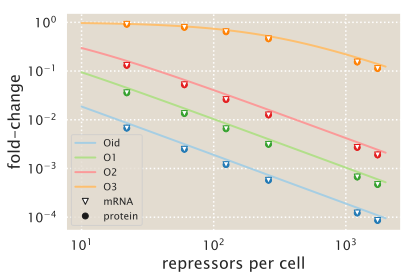

In [41]:
# Define range of repressors for which compute the thermo fold-change
r_array = np.logspace(1, np.log10(2000), 50)

# Group data frame by operator
df_group = df_fc_p.groupby('energy')

# Define colors
colors = sns.color_palette('Paired', n_colors=len(df_group) * 2)
# Loop through operator
for i, (group, data) in enumerate(df_group):
    # Compute thermo fold-change
    fold_change_thermo = (1 + r_array / Nns * np.exp(- group))**-1

    # Plot thermodynamic fold-change prediction
    plt.plot(r_array, fold_change_thermo, label=data.operator.unique()[0],
             color=colors[i * 2])
    # Plot the kinetic fold-change prediciton
    # Protein
    plt.plot(data.repressors.values, data.fold_change_p.values, lw=0, marker='o', 
             color=colors[(i * 2) + 1], label='')
    # mRNA
    plt.plot(data.repressors.values, data.fold_change_m.values, lw=0, marker='v', 
             markeredgecolor=colors[(i * 2) + 1], markeredgewidth=1,
             markerfacecolor='w', label='')

# Generate labels for mRNA and protein
plt.plot([], [], lw=0, marker='v', 
         markeredgecolor='k', markeredgewidth=1,
         markerfacecolor='w', label='mRNA')
plt.plot([], [], lw=0, marker='o', 
         color='k', label='protein')

# Change scale to log
plt.xscale('log')
plt.yscale('log')

# Label axis
plt.xlabel('repressors per cell')
plt.ylabel('fold-change')

# Set legend
plt.legend(fontsize=10)

The LacI titration still works with the given parameters, so we can systematically apply this to all moments of the distribution.

## Systematic moment computation with exponentially distributed cells

Just as before let's systematically vary the repressor copy number, the operator and inducer concentration to compute average moments over the cell cycle.

In [68]:
# Define mRNA rate
# http://bionumbers.hms.harvard.edu/bionumber.aspx?id=105717&ver=3&trm=lacZ%20mRNA%20lifetime&org=
gm = 1 / (3 * 60)

# Load the flat-chain
with open('../../data/mcmc/lacUV5_constitutive_mRNA_double_expo.pkl',
          'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()

# Generate a Pandas Data Frame with the mcmc chain
index = ['kp_on', 'kp_off', 'rm']

# Generate a data frame out of the MCMC chains
df_mcmc = pd.DataFrame(gauss_flatchain, columns=index)

# rerbsine the index with the new entries
index = df_mcmc.columns

# map value of the parameters
max_idx = np.argmax(gauss_flatlnprobability, axis=0)
kp_on, kp_off, rm = df_mcmc.iloc[max_idx, :] * gm

# Define protein production and degradatino rates
gp = 1 / 60**2 # sec^-1
rp = 1000 * gp # sec^-1

# Number of non-specific binding sites in thermodynamic model
Nns = 4.6E6

# Cell volume
Vcell = 2.15 # fL

# MWC induction parameters
ka = 139 # µM
ki = 0.53 # µM
epsilon = 4.5 # kBT

# Define time for single-promoter state
t_single = 60 * 1 / 3 * 60 # sec
# Define time for two-promoter state
t_double = 60 * 2 / 3 * 60 # sec
# Define number of cell cycles
n_cycles = 4

Now we define the matrices that won't change for all parameters given these parameter values

In [69]:
# Define the production matrix
Rm_reg = np.array([[rm, 0, 0],
                   [0, 0, 0],
                   [0, 0, 0]])
# Define the degradation matrix
Gm_reg = np.array([[gm, 0, 0],
                   [0, gm, 0],
                   [0, 0, gm]])

# Define the production matrix
Rp_reg = np.array([[rp, 0, 0],
                   [0, rp, 0],
                   [0, 0, rp]])

# Define the production matrix
Gp_reg = np.array([[gp, 0, 0],
                   [0, gp, 0],
                   [0, 0, gp]])

Let's now list the parameters that will be varied for the different strains.

In [70]:
# Define experimental concentrations in µM
inducer = [0, 0.1, 5, 10, 25, 50, 75, 100, 250, 500, 1000, 5000] # µM

# Define repressor copy numebers
repressors = np.logspace(0, np.log10(2000), 20)
repressors = np.unique(repressors.round(0))

# Include repressor copy numbers for experimentally available strains
rep = [0, 11, 30, 62, 130, 610, 870]
# Include repressor dimers into the list
rep = rep + [r * 2 for r in rep[1:]]
# Add them to list
repressors =  np.concatenate([repressors, rep])

# Define operators and energies
operators = ['O1', 'O2', 'O3']
energies = [-15.3, -13.9, -9.7]
op_dict = dict(zip(operators, energies))

Now given these parameters let's compute the moments, that will serve as constraints for the MaxEnt distribution.

In [77]:
# Define index of moments to be used in the computation
moments = [(1, 0), (2, 0), (3, 0),
           (0, 1), (1, 1), (0, 2),
           (2, 1), (1, 2), (0, 3)]

# Initialize data frame to save the lagrange multipliers.
names = ['operator', 'binding_energy', 'repressor', 'inducer_uM']
names = names + ['m' + str(m[0]) + 'p' + str(m[1]) for m in moments]         

# Initialize DataFrame to save constraints
df_constraints = pd.DataFrame([], columns=names)

compute_constraints = False
if compute_constraints:
    # Loop through operators
    for op in operators:
        print(op)
        eRA = op_dict[op]
        # Loop through repressor copy numbers
        for rep in repressors:
            # Loop through IPTG concentrations
            for iptg in inducer:
                # Calculate the repressor on rate including the MWC model
                kr_on = ko * rep * chann_cap.p_act(iptg, ka, ki, epsilon) 

                # Compute the repressor off-rate based on the on-rate and 
                # the binding energy
                kr_off = chann_cap.kr_off_fun(eRA, ko, kp_on, kp_off, Nns, Vcell)

                # Define the rate constant matrix
                Km_reg = np.array([[-kp_off, kp_on, 0], 
                                   [kp_off, -(kp_on + kr_on), kr_off],
                                   [0, kr_on, -kr_off]])

                # Define initial conditions
                m0_init = [0.3, 0.3, 0.4]
                m1_init = [0, 0, 0]
                m2_init = [0, 0, 0]
                m3_init = [0, 0, 0]
                p1_init = [0, 0, 0]
                mp_init = [0, 0, 0]
                p2_init = [0, 0, 0]
                m2p_init = [0, 0, 0]
                mp2_init = [0, 0, 0]
                p3_init = [0, 0, 0]

                # Define time on which to perform integration
                t = np.linspace(0, 100 * 60, 301)
                # Numerically integrate equations
                m_init = sp.integrate.odeint(dpdt, 
                                             m0_init + m1_init + m2_init + m3_init +
                                             p1_init + mp_init + p2_init + m2p_init +
                                             mp2_init + p3_init,
                                             t, 
                                             args=(Km_reg, Rm_reg, Gm_reg,
                                                   Rp_reg, Gp_reg))
                # Keep last time point as initial condition
                m_init = m_init[-1, :]

                # Integrate moment equations
                df = dpdt_cycles(m_init, t_single, t_double, n_cycles,
                                 Km_reg, Rm_reg, Gm_reg, Rp_reg, Gp_reg,
                                 n_steps=300,
                                 states=['P', 'E', 'R'])

                # Keep only last cycle
                df = df[df['cycle'] == df['cycle'].max()]

                # Define array for integration
                a_array = np.linspace(0, 1, len(df))
                # Compute probability based on this array
                p_a_array = np.log(2) * 2**(1 - a_array)
                
                # Initialize list to append moments
                moms = list()
                # Loop through moments computing the average moment
                for i, mom in enumerate(moments):
                    # Generate string that finds the moment
                    mom_name = 'm' + str(mom[0]) + 'p' + str(mom[1])
                    # List rows with moment
                    mom_bool = [x for x in df.columns if mom_name in x]
                    # Extract data for this particular moment
                    df_mom = df.loc[:, mom_bool].sum(axis=1)
   
                    # Average moment and append it to list
                    moms.append(sp.integrate.simps(df_mom * p_a_array,
                                                   a_array))
                
                # Save results into series in order to append it to data frame
                series = pd.Series([op, eRA, rep, iptg] + moms,
                           index=names)
    
                # Append to DataFrame
                df_constraints = df_constraints.append(series, ignore_index=True)

                # Save progress at each step
                df_constraints.to_csv(datadir + 'MaxEnt_multi_promoter_cell_division_expo_dist_constraints.csv',
                          index=False)
                
df_constraints = pd.read_csv(datadir + 'MaxEnt_multi_promoter_cell_division_expo_dist_constraints.csv')
df_constraints.head()

,operator,binding_energy,repressor,inducer_uM,m1p0,m2p0,m3p0,m0p1,m1p1,m0p2,m2p1,m1p2,m0p3
0,O1,-15.3,1.0,0.0,6.467485,102.341980,2250.832047,4002.492461,32068.540874,2.293847e+07,5.607387e+05,2.067528e+08,1.482838e+11
1,O1,-15.3,1.0,0.1,6.483548,102.678091,2259.250295,4012.432819,32217.841814,2.304541e+07,5.637506e+05,2.081240e+08,1.492738e+11
2,O1,-15.3,1.0,5.0,9.098674,159.294697,3705.070059,5630.664996,60527.345790,4.334147e+07,1.156532e+06,5.085687e+08,3.673223e+11
3,O1,-15.3,1.0,10.0,11.457328,212.608384,5099.743933,7090.101502,92409.674990,6.623280e+07,1.855442e+06,9.213137e+08,6.693271e+11
4,O1,-15.3,1.0,25.0,13.549668,261.004861,6382.117077,8384.676761,125247.590797,8.983443e+07,2.594386e+06,1.407448e+09,1.027377e+12


### Comparing constraints with single-promoter model.

Let's take a look at how different the constraints are between a single promoter model and a multi-promoter model. First let's compare the first mRNA and protein moment. This we expect them to be quite similar.

/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


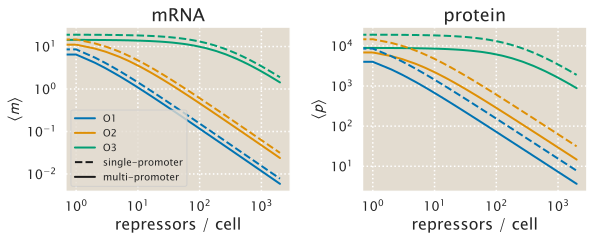

In [78]:
# Read constraints for the single promoter model
df_constraints_single = pd.read_csv(datadir +
                                    'MaxEnt_ss_constraints.csv')
df_constraints_single = df_constraints_single\
                        [df_constraints_single.operator != 'Oid']

# Group both
df_group = df_constraints.sort_values('repressor')\
          [df_constraints.inducer_uM == 0].groupby('operator')
df_single_group = df_constraints_single.sort_values('repressor')\
          [df_constraints_single.inducer_uM == 0].groupby('operator')

# Define colors for plot
colors = sns.color_palette('colorblind', n_colors=len(df_group))

# Initialize figure
fig, ax = plt.subplots(1, 2, figsize=(8.5, 3.5), sharey=False, sharex=True)

# Loop through the groups and plot protein first moment
for i, (group, data) in enumerate(df_group):
    ax[0].plot(data.repressor, data.m1p0, label=group, color=colors[i])
    ax[1].plot(data.repressor, data.m0p1, label=group, color=colors[i])

    
for i, (group, data) in enumerate(df_single_group):
    ax[0].plot(data.repressor, data.m1p0, color=colors[i],
             linestyle='--', label='')
    ax[1].plot(data.repressor, data.m0p1, color=colors[i],
             linestyle='--', label='')

# Generate legend for single vs double promoter
ax[0].plot([], [], color='k', linestyle='--', label='single-promoter')
ax[0].plot([], [], color='k', label='multi-promoter')

# Change plot scale
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_yscale('log')

# Label axis
ax[0].set_xlabel('repressors / cell')
ax[1].set_xlabel('repressors / cell')
ax[0].set_ylabel(r'$\left\langle m \right\rangle$')
ax[1].set_ylabel(r'$\left\langle p \right\rangle$')

# Set title
ax[0].set_title('mRNA')
ax[1].set_title('protein')

# Include legend
ax[0].legend(fontsize=10)
plt.tight_layout()

#### Fano factor

Let's now look at the Fano-factor for both molecules. For this we expect the multi-promoter case to be larger since it is more noisy than the single promoter case.

/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


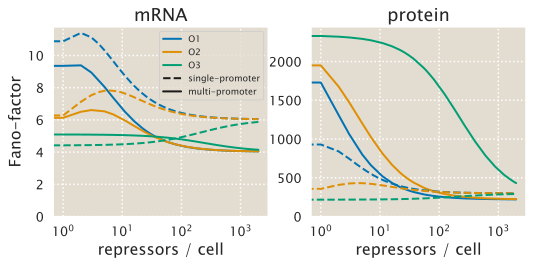

In [79]:
# Group both
df_group = df_constraints.sort_values('repressor')\
          [df_constraints.inducer_uM == 0].groupby('operator')
df_single_group = df_constraints_single.sort_values('repressor')\
          [df_constraints_single.inducer_uM == 0].groupby('operator')

# Define colors for plot
colors = sns.color_palette('colorblind', n_colors=len(df_group))

# Initialize figure
fig, ax = plt.subplots(1, 2, figsize=(8.5, 3.5), sharey=False, sharex=True)

# Loop through the groups and plot protein first moment
for i, (group, data) in enumerate(df_group):
    ax[0].plot(data.repressor, (data.m2p0 - data.m1p0**2) / data.m1p0, label=group, color=colors[i])
    ax[1].plot(data.repressor, (data.m0p2 - data.m0p1**2) / data.m0p1, label=group, color=colors[i])

    
for i, (group, data) in enumerate(df_single_group):
    ax[0].plot(data.repressor, (data.m2p0 - data.m1p0**2) / data.m1p0, color=colors[i],
             linestyle='--', label='')
    ax[1].plot(data.repressor, (data.m0p2 - data.m0p1**2) / data.m0p1, color=colors[i],
             linestyle='--', label='')

# Generate legend for single vs double promoter
ax[0].plot([], [], color='k', linestyle='--', label='single-promoter')
ax[0].plot([], [], color='k', label='multi-promoter')

# Change plot scale
ax[0].set_xscale('log')
ax[1].set_xscale('log')

# Set plot so that it shows where 0 in the y-axis is
ax[0].set_ylim(bottom=0)
ax[1].set_ylim(bottom=0)

# Label axis
ax[0].set_xlabel('repressors / cell')
ax[1].set_xlabel('repressors / cell')
ax[0].set_ylabel(r'Fano-factor')

# Set title
ax[0].set_title('mRNA')
ax[1].set_title('protein')

# Include legend
ax[0].legend(fontsize=9)

#### Skewness

Let's finally look at the skewness (related to the third moment) to see how much this moment changes relatively to the other moments.

The skweness is defined as
$$
\ee{\left( {X - \ee{X} \over \sigma_X} \right)^3} =
{\ee{X^3} - 3 \ee{X} \sigma_X^2 + 2 \ee{X}^3 \over \sigma_X^3},
$$
whre $\sigma_X$ is the standard deviation of variable $X$.

/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


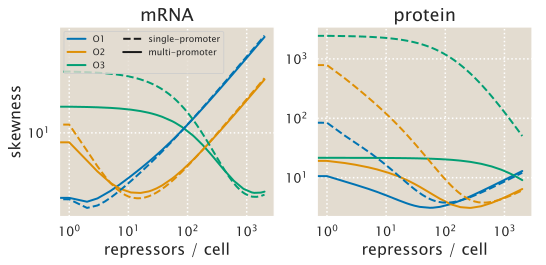

In [80]:
# Group both
df_group = df_constraints.sort_values('repressor')\
          [df_constraints.inducer_uM == 0].groupby('operator')
df_single_group = df_constraints_single.sort_values('repressor')\
          [df_constraints_single.inducer_uM == 0].groupby('operator')

# Define colors for plot
colors = sns.color_palette('colorblind', n_colors=len(df_group))

# Initialize figure
fig, ax = plt.subplots(1, 2, figsize=(8.5, 3.5), sharey=False, sharex=True)

# Loop through the groups and plot protein first moment
for i, (group, data) in enumerate(df_group):
    std = np.sqrt(data.m2p0 - data.m1p0**2)
    skewness = (data.m3p0 - 3 * data.m1p0 * std**2 + 2 * data.m1p0**3) / std**3
    ax[0].plot(data.repressor, skewness, label=group, color=colors[i])
    
    std = np.sqrt(data.m0p2 - data.m0p1**2)
    skewness = (data.m0p3 - 3 * data.m0p1 * std**2 + 2 * data.m0p1**3) / std**3
    ax[1].plot(data.repressor, skewness, label=group, color=colors[i])

    
for i, (group, data) in enumerate(df_single_group):
    std = np.sqrt(data.m2p0 - data.m1p0**2)
    skewness = (data.m3p0 - 3 * data.m1p0 * std**2 + 2 * data.m1p0**3) / std**3
    ax[0].plot(data.repressor, skewness, color=colors[i],
             linestyle='--', label='')
    
    std = np.sqrt(data.m0p2 - data.m0p1**2)
    skewness = (data.m0p3 - 3 * data.m0p1 * std**2 + 2 * data.m0p1**3) / std**3
    ax[1].plot(data.repressor, skewness, color=colors[i],
             linestyle='--', label='')

# Generate legend for single vs double promoter
ax[0].plot([], [], color='k', linestyle='--', label='single-promoter')
ax[0].plot([], [], color='k', label='multi-promoter')

# Change plot scale
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[1].set_xscale('log')
ax[1].set_yscale('log')



# Label axis
ax[0].set_xlabel('repressors / cell')
ax[1].set_xlabel('repressors / cell')
ax[0].set_ylabel(r'skewness')

# Set title
ax[0].set_title('mRNA')
ax[1].set_title('protein')

# Include legend
ax[0].legend(fontsize=9, ncol=2)

#### Computing the Maximum entropy distribution

Having computed the constraints let's go ahead and perform the MaxEnt optimization to obtain the Lagrange multipliers.

In [72]:
# Define index of moments to be used in the computation
moments = [(1, 0), (2, 0), (3, 0),
           (0, 1), (1, 1), (0, 2),
           (2, 1), (1, 2), (0, 3)]

# Define sample space
mRNA_space = np.arange(0, 50)
protein_space = np.arange(0, 2E4)
# Generate sample space as a list of pairs using itertools.
samplespace = list(itertools.product(mRNA_space, protein_space))

# Initialize matrix to save all the features that are fed to the
# maxentropy function
features = np.zeros([len(moments), len(samplespace)])

# Loop through constraints and compute features
for i, mom in enumerate(moments):
    features[i, :] = [chann_cap.feature_fn(x, mom) for x in samplespace]

In [81]:
# Initialize data frame to save the lagrange multipliers.
names = ['operator', 'binding_energy', 'repressor', 'inducer_uM']

names = names + ['lambda_m' + str(m[0]) + 'p' + str(m[1]) for m in moments]

df_maxEnt = pd.DataFrame([], columns=names)

# Define column names containing the constraints used to fit the distribution
constraints_names = ['m' + str(m[0]) + 'p' + str(m[1]) for m in moments]

fit_dist = True
if fit_dist:
    # Define function for parallel computation
    def maxEnt_parallel(idx, df):
        # Report on progress
        print('iteration: ',idx)
            
        # Extract constraints
        constraints = df.loc[constraints_names]
        
        # Perform MaxEnt computation
        Lagrange = chann_cap.MaxEnt_bretthorst(constraints, features, 
                                               algorithm='BFGS')
        # Save Lagrange multipliers into dataframe
        series = pd.Series(Lagrange, index=names[4::])
        
        # Add other features to series before appending to dataframe
        series = pd.concat([df.drop(constraints_names), series])
        
        return series
    
    # Run the function in parallel
    maxEnt_series = Parallel(n_jobs=6)(delayed(maxEnt_parallel)(idx, df)
                           for idx, df in df_constraints.iterrows())
    
    # Initialize data frame to save list of parameters
    df_maxEnt = pd.DataFrame([], columns=names)

    for s in maxEnt_series:
        df_maxEnt = df_maxEnt.append(s, ignore_index=True)

    df_maxEnt.to_csv(datadir +
    'MaxEnt_ss_Lagrange_multipliers_cell_division_expo_dist.csv')
    
df_maxEnt = pd.read_csv(datadir +
            'MaxEnt_ss_Lagrange_multipliers_cell_division_expo_dist.csv')
df_maxEnt.head()

,Unnamed: 0,operator,binding_energy,repressor,inducer_uM,lambda_m1p0,lambda_m2p0,lambda_m3p0,lambda_m0p1,lambda_m1p1,lambda_m0p2,lambda_m2p1,lambda_m1p2,lambda_m0p3
0,0,O1,-15.3,1.0,0.0,-0.357083,0.011117,-0.000161,-0.001174,5.631002e-06,3.196876e-07,-3.970602e-07,2.346519e-09,-2.674010e-11
1,1,O1,-15.3,1.0,0.1,-0.355870,0.011057,-0.000160,-0.001174,5.571046e-06,3.190727e-07,-3.952438e-07,2.340238e-09,-2.663641e-11
2,2,O1,-15.3,1.0,5.0,-0.174790,0.002454,-0.000040,-0.001146,-3.580058e-07,2.531283e-07,-2.143039e-07,1.637228e-09,-1.622998e-11
3,3,O1,-15.3,1.0,10.0,-0.007275,-0.005298,0.000062,-0.001175,-2.360576e-06,2.242087e-07,-1.436352e-07,1.290109e-09,-1.208291e-11
4,4,O1,-15.3,1.0,25.0,0.188621,-0.014276,0.000177,-0.001230,-2.834771e-06,2.101693e-07,-1.034892e-07,1.063090e-09,-9.997258e-12
